импортируем нужные библиотеки

In [2]:
import re
import pickle
import time
import math
import random as rd
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
from nltk.corpus import stopwords
from tokenizers import Tokenizer,models,trainers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score,precision_score,accuracy_score
from sklearn import preprocessing
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset,random_split

считываем новости

новости считанные с lenta news

In [3]:
lenta_news = pd.read_csv('lenta_news.csv')
lenta_news

,title,text,topic
0,МВД создало бюро по борьбе с отмыванием денег,В МВД России создано оперативно-розыскное бюро...,Экономика
1,Правительство не будет занимать деньги у ЦБ,Правительство не будет прибегать к заимствован...,Экономика
2,"ВВС США заказали 60 ""Боингов"" для вторжения в ...",Компания Boeing получит пятилетний контракт на...,Экономика
3,Правительственная комиссия не дала ExxonMobil ...,Результаты конкурса на право освоения месторож...,Экономика
4,Неимущим для получения пособия придется расста...,В доходах малоимущих россиян будут учитываться...,Экономика
...,...,...,...
23944,"Борис Гребенщиков награжден орденом ""За заслуг...","Лидер легендарной группы ""Аквариум"" Борис Греб...",Культура
23945,Мадонна и Траволта названы худшими актерами года,"24 марта, накануне вручения премии Американско...",Культура
23946,Габриэль Гарсиа Маркес простил Голливуд ради д...,Габриэль Гарсиа Маркес,Культура
23947,Аль Пачино отстоял в суде свое право на детей,Знаменитый американский актер Аль Пачино добил...,Культура


новости считанные с rbk news

In [31]:
rbk_news = pd.read_csv('rbk_news.csv',header = None)
rbk_news

,0,1
0,США обеспокоены участием военных КНДР в военно...,Политика
1,"Пхеньян, по ее словам «не помогает» в урегулир...",Политика
2,США «по-прежнему обеспокоены прямым участием» ...,Политика
3,«Переброска на территорию России военных [КНДР...,Политика
4,\n\n\n\n\n\n\n Минобороны п...,Политика
...,...,...
1170,\n\n\n\n\n\n\n ЦБ подумает ...,Финансы
1171,В отличие от стратегий автоследования в ОПИФе ...,Финансы
1172,\n\n\n\n\n\n\n Индекс Мосби...,Финансы
1173,Идею привлечения авторов инвестиционных блогов...,Финансы


выводим название всех таргетов (типов новостей) для каждой новости с целью их последующего объеденения

In [17]:
rbk_news.iloc[:,1].unique()

array(['Политика', 'Экономика', 'Бизнес', 'Технологии и медиа', 'Финансы'],
      dtype=object)

In [16]:
lenta_news.iloc[:,2].unique()

array(['Экономика', 'Интернет и СМИ', 'Спорт', 'Культура'], dtype=object)

In [37]:
rbk_news.loc[rbk_news[1] == 'Технологии и медиа',1] = 'Интернет и СМИ'

In [42]:
rbk_news[1].unique()

array(['Политика', 'Экономика', 'Бизнес', 'Интернет и СМИ', 'Финансы'],
      dtype=object)

In [46]:
lenta_news.iloc[:,2].unique()

array(['Экономика', 'Интернет и СМИ', 'Спорт', 'Культура'], dtype=object)

In [49]:
all_classes = list(set(rbk_news[1].unique().tolist() + lenta_news.iloc[:,2].unique().tolist()))

In [51]:
print(len(all_classes))
all_classes

7


['Экономика',
 'Бизнес',
 'Финансы',
 'Культура',
 'Интернет и СМИ',
 'Спорт',
 'Политика']

In [65]:
lent_text_col = pd.DataFrame({'Text':[lenta_news.iloc[row,0]+ ' ' +lenta_news.iloc[row,1] for row in range(len(lenta_news))]})

In [ ]:
lenta_news.insert(loc = 0,column = 'Text',value = lent_text_col['Text'])

In [80]:
lenta_news.drop(['title','text'],axis = 1,inplace = True)

In [81]:
lenta_news

,Text,topic
0,МВД создало бюро по борьбе с отмыванием денег ...,Экономика
1,Правительство не будет занимать деньги у ЦБ Пр...,Экономика
2,"ВВС США заказали 60 ""Боингов"" для вторжения в ...",Экономика
3,Правительственная комиссия не дала ExxonMobil ...,Экономика
4,Неимущим для получения пособия придется расста...,Экономика
...,...,...
23944,"Борис Гребенщиков награжден орденом ""За заслуг...",Культура
23945,Мадонна и Траволта названы худшими актерами го...,Культура
23946,Габриэль Гарсиа Маркес простил Голливуд ради д...,Культура
23947,Аль Пачино отстоял в суде свое право на детей ...,Культура


In [83]:
rbk_news.columns = ['Text','topic']

In [84]:
rbk_news

,Text,topic
0,США обеспокоены участием военных КНДР в военно...,Политика
1,"Пхеньян, по ее словам «не помогает» в урегулир...",Политика
2,США «по-прежнему обеспокоены прямым участием» ...,Политика
3,«Переброска на территорию России военных [КНДР...,Политика
4,\n\n\n\n\n\n\n Минобороны п...,Политика
...,...,...
1170,\n\n\n\n\n\n\n ЦБ подумает ...,Финансы
1171,В отличие от стратегий автоследования в ОПИФе ...,Финансы
1172,\n\n\n\n\n\n\n Индекс Мосби...,Финансы
1173,Идею привлечения авторов инвестиционных блогов...,Финансы


In [96]:
print(rbk_news.columns)
print(lenta_news.columns)
rbk_news.columns == lenta_news.columns

Index(['Text', 'topic'], dtype='object')
Index(['Text', 'topic'], dtype='object')


array([ True,  True])

объеденяем все новости в один датафрайм

In [97]:
all_news_data = pd.concat([lenta_news,rbk_news],axis = 0,ignore_index=True)

In [100]:
all_news_data

,Text,topic
0,МВД создало бюро по борьбе с отмыванием денег ...,Экономика
1,Правительство не будет занимать деньги у ЦБ Пр...,Экономика
2,"ВВС США заказали 60 ""Боингов"" для вторжения в ...",Экономика
3,Правительственная комиссия не дала ExxonMobil ...,Экономика
4,Неимущим для получения пособия придется расста...,Экономика
...,...,...
25119,\n\n\n\n\n\n\n ЦБ подумает ...,Финансы
25120,В отличие от стратегий автоследования в ОПИФе ...,Финансы
25121,\n\n\n\n\n\n\n Индекс Мосби...,Финансы
25122,Идею привлечения авторов инвестиционных блогов...,Финансы


In [103]:
labels = all_news_data['topic'].unique()
print(len(labels))
labels

7


array(['Экономика', 'Интернет и СМИ', 'Спорт', 'Культура', 'Политика',
       'Бизнес', 'Финансы'], dtype=object)

In [99]:
all_news_data.to_csv('all_news_data.csv')

In [117]:
for one_label in labels:
    the_one = all_news_data.loc[all_news_data['topic'] == one_label,'Text'].iloc[rd.randint(0,300)]
    print(one_label)
    print(the_one)
    print('\n\n')

Экономика
Касьянов заинтересовал Словакию новым газопроводом Словацкая сторона проявила "заметный интерес" к идее строительства газопровода по своей территории для транспортировки российского газа в Европу, об этом заявлено на встрече премьер-министра РФ Михаила Касьянова и министра экономики Словакии Любомира Гараха в среду в московском Доме правительства. Как сообщают из Департамента правительственной информации, Словакия уже заявила, что придает большое значение этому проекту, который свяжет магистральные газопроводы на территории Словакии и Польши. Сооружение новой нитки газопровода через Словакию позволит направить российский газ с Ямала в Европу в обход Украины, которая продолжает прибегать к несанкционированным заборам российского газа. Потери России от действий Украины оцениваются в несколько миллиардов кубических  метров в год. Беседа Касьянова и Гараха состоялась в рамках обсуждения итогов прошедшего накануне заседания российско-словацкой межправительственной комиссии по науч

In [9]:
all_news = pd.read_csv('all_news_data.csv',index_col = 0)

разделяем данные на тестовую и обучающую выборку таким образом, чтобы распределения классов в них было одинаковым

In [138]:
Train_news,Test_news = train_test_split(all_news,stratify=all_news['topic'],train_size=0.93)

In [139]:
print(len(Train_news))
print(len(Test_news))

23365
1759


In [ ]:
# Train_news.to_csv('Train_news.csv')
# Test_news.to_csv('Test_news.csv')

In [3]:
Train_news,Test_news = pd.read_csv('Train_news.csv',index_col=0),pd.read_csv('Test_news.csv',index_col=0)

In [ ]:
# Test_news = Test_news.reset_index().drop(['index'],axis = 1)
# Train_news = Train_news.reset_index().drop(['index'],axis = 1)

In [4]:
print(len(Train_news))
print(len(Test_news))

23364
1759


In [5]:
print(len(Train_news))
Train_news.iloc[:5,:]

23364


,Text,topic
0,"Украина готова вернуть ""взятый по ошибке"" кред...",Экономика
1,Рио-де-Жанейро стал кандидатом на роль столицы...,Спорт
2,Скончался драматург и сценарист Александр Воло...,Культура
3,Испанец пересек Атлантический океан на водном ...,Спорт
4,"Украина на Новый год останавливает все, что дв...",Интернет и СМИ


In [6]:
print(len(Test_news))
Test_news.iloc[:5,:]

1759


,Text,topic
0,"Падение фондового рынка возглавили ""ЮКОС"" и ""Г...",Экономика
1,Контрабанда нефти из Ирака достигла рекордного...,Экономика
2,"Андрей Шевченко продлил контракт с ""Миланом"" д...",Спорт
3,Американцы запрещают детям играть в компьютерн...,Интернет и СМИ
4,Napster идет маршем на Вашингтон Napster призы...,Интернет и СМИ


In [8]:
len(Test_news)

1759

In [13]:
len(Test_news.dropna())

1759

In [ ]:
# Train_news.dropna(inplace=True)
# Train_news.reset_index().drop('index',axis = 1,inplace = True)

тут мы просто сохраняем для последующего использования

In [ ]:
# Train_news.to_csv('Train_news.csv')

выводи русские стоп слова для их последующего использования

In [3]:
russian_stopwords = stopwords.words('russian')
print(len(russian_stopwords))
russian_stopwords[:10]

151


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

напишем функцию, которая будет нормализовывать текст следующим образом:    
1)удаление всех символов кроме русских и английсских цифр и букв    
2)удаление всех русских стоп-слов 

In [4]:
def normalize_text(the_text):
    lowered = the_text.lower()
    found = re.findall(r'[А-я0-9A-z]+',lowered)
    filtered_found = [word for word in found if word != '' and word not in russian_stopwords]
    return filtered_found

выводим тут пример

In [20]:
example_text = Train_news.iloc[3,0]
example_text

'Испанец пересек Атлантический океан на\xa0водном мотоцикле Испанец Альваро де Маричалар (Alvaro de Marichalar) пересек Атлантический океан на водном мотоцикле, сообщает в воскресенье BBC News. Маричалар начал свое путешествие четыре месяца в Риме. Проплыв по реке Тибр до Средиземного моря, он делал остановки в Марокко, на Гибралтаре и на Канарских островах. Достигнув Атлантического океана, путешественник посетил Кубу и в Доминиканскую республику. Конечной точкой маршрута Маричалара стал Майами, США. Маричалар ехал 12 часов в сутки. На протяжении всего маршрута его сопровождало судно с командой из шести человек на борту, которое перевозило еду и топливо для водного мотоцикла. По словам испанца, он потратил на подготовку к путешествию несколько лет, и поправился на 18 килограмм, чтобы компенсировать потерю веса во время прохождения маршрута. Отвечая на вопрос журналистов, что было самым тяжелым во время пересечения Атлантического океана, Маричалар ответил: "Холод. По дороге из Рима в Не

создаем генератор, который будет генерировать нормализованне текст (токены) из колонки текстового описания новостей

In [20]:
def cleared_texts(text_col):
    for ith_row in range(len(text_col)):
        for token in normalize_text(text_col.iloc[ith_row]):
            yield token

In [22]:
tokens_dataset = cleared_texts(Train_news['Text'])

с помощью библиотеки hugging face мы создаем тренировочны словарь (словарь из всех токенов которые содержатся во всех новостях тренировочного набора дданных)

In [23]:
wordlevel_trainer = trainers.WordLevelTrainer(vocab_size = 500_000,show_progress = True,special_tokens = ['[UNK]','[PAD]'],min_frequency = 5)
wordlevel_model = models.WordLevel()
Train_tokenizer = Tokenizer(model = wordlevel_model)

In [24]:
Train_tokenizer.train_from_iterator(tokens_dataset,trainer=wordlevel_trainer)

фиксируем полученный словарь и создаём функцию для помследующей его загрузки 

In [ ]:
# Train_tokenizer.get_vocab_size()

57568

In [ ]:
# with open('Train_tokenizer.pkl','wb') as file:
#     pickle.dump(Train_tokenizer,file)

In [26]:
with open('Train_tokenizer.pkl','rb') as file:
    Train_tokenizer = pickle.load(file)

In [28]:
Train_tokenizer.get_vocab_size()

57568

In [65]:
test_tokens_dataset = cleared_texts(Test_news['Text'])

In [66]:
wordlevel_trainer = trainers.WordLevelTrainer(vocab_size = 500_000,show_progress = True,special_tokens = ['[UNK]','[PAD]'])
wordlevel_model = models.WordLevel()
Test_tokenizer = Tokenizer(model = wordlevel_model)

In [67]:
Test_tokenizer.train_from_iterator(test_tokens_dataset,trainer=wordlevel_trainer)

In [75]:
Test_tokenizer.get_vocab_size()

51219

In [ ]:
# with open('Test_tokenizer.pkl','wb') as file:
#     pickle.dump(Test_tokenizer,file)

собираем всен нужные функции в одно место

In [12]:
#loading main functions
def normalize_text(the_text):
    lowered = the_text.lower()
    found = re.findall(r'[А-я0-9A-z]+',lowered)
    filtered_found = [word for word in found if word != '' and word not in russian_stopwords]
    return filtered_found


def cleared_texts(text_col):
    for ith_row in range(len(text_col)):
        for token in normalize_text(text_col.iloc[ith_row]):
            yield token


russian_stopwords = stopwords.words('russian')
print(len(russian_stopwords))
russian_stopwords[:10]

151


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

загружаем наши данные разделенные на тестовую и обучающую 

In [6]:
#loading datasets
Train_news,Test_news = pd.read_csv('Train_news.csv',index_col=0),pd.read_csv('Test_news.csv',index_col=0)

In [7]:
#loading saved tokenizers
with open('Train_tokenizer.pkl','rb') as file:
    Train_tokenizer = pickle.load(file)

with open('Test_tokenizer.pkl','rb') as file:
    Test_tokenizer = pickle.load(file)

проверяем что все нормально

In [8]:
Train_news.iloc[:3,0]

0    Украина готова вернуть "взятый по ошибке" кред...
1    Рио-де-Жанейро стал кандидатом на роль столицы...
2    Скончался драматург и сценарист Александр Воло...
Name: Text, dtype: object

In [9]:
Test_news.iloc[:3,0]

0    Падение фондового рынка возглавили "ЮКОС" и "Г...
1    Контрабанда нефти из Ирака достигла рекордного...
2    Андрей Шевченко продлил контракт с "Миланом" д...
Name: Text, dtype: object

In [10]:
print(Test_tokenizer.get_vocab_size())
print(Train_tokenizer.get_vocab_size())

51219
57568


In [9]:
#train the embeddings (3 types)
#n_grams
embd_training_text_list = list(cleared_texts(Train_news['Text']))
embd_test_text_list = list(cleared_texts(Test_news['Text']))

In [10]:
print(embd_training_text_list[:5])
print(embd_test_text_list[:5])

['украина', 'готова', 'вернуть', 'взятый', 'ошибке']
['падение', 'фондового', 'рынка', 'возглавили', 'юкос']


теперь нужно создать такой датасет, чтобы по нему было возможно обучение первой модели векторных представлений ngram

In [11]:
def create_n_grams(list_of_tokens,window_size):
    '''creates N-grams with specified window'''
    for ind in range(window_size,len(list_of_tokens)-window_size):
        n_grams = []
        #adding the words in window to the list
        for window_gap in range(1,window_size + 1):
            n_grams.append(list_of_tokens[ind - window_gap])
        for window_gap in range(1,window_size + 1):
            n_grams.append(list_of_tokens[ind + window_gap])
        #yielding the result so that we can save some memory)
        yield n_grams,list_of_tokens[ind]

создаем обучающий датасет для обучения модели ngram (окно будем брать по два слова из прошлого и будущего)    
подробнее смотреть в аналитической записке

In [12]:
train_n_grams = create_n_grams(embd_training_text_list,window_size=2)
test_n_grams = create_n_grams(embd_test_text_list,window_size=2)

проверяем, что датасет создался правильным образом

In [13]:
#example
print(next(train_n_grams))
print(next(train_n_grams))
print(next(train_n_grams))

(['готова', 'украина', 'взятый', 'ошибке'], 'вернуть')
(['вернуть', 'готова', 'ошибке', 'кредит'], 'взятый')
(['взятый', 'вернуть', 'кредит', 'мвф'], 'ошибке')


In [14]:
print(next(test_n_grams))
print(next(test_n_grams))
print(next(test_n_grams))

(['фондового', 'падение', 'возглавили', 'юкос'], 'рынка')
(['рынка', 'фондового', 'юкос', 'газпром'], 'возглавили')
(['возглавили', 'рынка', 'газпром', 'настоящее'], 'юкос')


In [15]:
embd_test_text_list[:10]

['падение',
 'фондового',
 'рынка',
 'возглавили',
 'юкос',
 'газпром',
 'настоящее',
 'время',
 '16',
 '00']

In [16]:
embd_training_text_list[:10]

['украина',
 'готова',
 'вернуть',
 'взятый',
 'ошибке',
 'кредит',
 'мвф',
 'украина',
 'готова',
 'вернуть']

на овнове датасета полученного сверху создается датасет предназначенный для обученя модели с помощью библиотеки Pytorch    
класс основывается на класс Pytorch Dataset    
он возвращает объекты обучающего множества ngram но в виде индексов из словаря

In [12]:
class NGramDataset(Dataset):
    def __init__(self,tokenizer,the_data):
        self.main_data = the_data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.main_data)
    
    def __getitem__(self,indx):
        X = torch.tensor([self.tokenizer.token_to_id(word) if self.tokenizer.token_to_id(word) != None else self.tokenizer.token_to_id('[UNK]') for word in self.main_data[indx][0]],dtype=torch.long)
        true_word = self.main_data[indx][1]
        y = self.tokenizer.token_to_id(true_word) if self.tokenizer.token_to_id(true_word) != None else self.tokenizer.token_to_id('[UNK]')
        return X,y

In [174]:
Train_Ngramsdataset = NGramDataset(Train_tokenizer,list(train_n_grams))

In [241]:
#saving this dataset
# with open('/home/luchian/all_data/uni_data/Train_Ngramsdataset','wb') as file:
#     pickle.dump(Train_Ngramsdataset,file)

In [13]:
#loading this dataset
with open('/home/luchian/all_data/uni_data/Train_Ngramsdataset','rb') as file:
    Train_Ngramsdataset = pickle.load(file)

In [14]:
print(len(Train_Ngramsdataset))
print(Train_Ngramsdataset[339823])

3153657
(tensor([8481,   69,  670,  370]), 140)


создаем модель для обучения векторных представлений ngram (подробнее про архитектуру модели смотреть в аналитичнской записка)

In [ ]:
class NGramModel(nn.Module):
    def __init__(self,vocab_size,dim_embed,window_size = 2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed)
        #from both sides
        self.linear1 = nn.Linear(2*window_size*dim_embed,128)
        self.linear2 = nn.Linear(128,vocab_size)
        self.rel = nn.ReLU()

    def forward(self,ind_list):
        y = self.embed(ind_list)
        y = y.reshape(y.shape[0],-1)
        y = self.rel(self.linear1(y))
        y = self.linear2(y)
        return y

создаем функцию для обучения мрдели ngram    
она представляется из себя проход по всем данным за одну эпоху    
выисление результаты модели, подсчет ошибки, backprop и шаг оптимизатор

In [36]:
#training
def train_ngram_model(the_model,epoch,loader,optimizer,loss_func,dev = 'cuda'):
    for one_ep in range(epoch):
        the_model.train()
        the_losses = []
        for X,y in tqdm(loader,desc = 'Going through the loader'):
            X,y = X.to(device = 'cuda'),y.to(device = 'cuda')
            optimizer.zero_grad()
            y_pred = the_model(X)
            the_loss = loss_func(y_pred,y)
            the_loss.backward()
            the_losses.append(the_loss.item())
            optimizer.step()
        if one_ep%1== 0:
            print(f'Current Loss: {np.array(the_losses).mean()}')

создаются все параметры нужные для обучения модели

In [70]:
#setting the model
vocab_size = Train_tokenizer.get_vocab_size()
ngram_model = NGramModel(vocab_size,dim_embed = 100,window_size = 2)
ngram_model.to(device = 'cuda')

NGramModel(
  (embed): Embedding(57568, 100)
  (linear1): Linear(in_features=400, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=57568, bias=True)
  (rel): ReLU()
)

далее представлен коду обучения моделей (некоторые ячейки содержат в себе ошибку KeyboarInterrup так как обучения модели было временно преостановено в какой-то момент)    
модель ngram обучалась для векторных представлений размерности 150 и 300    
некоторые модели обучались в google colab в виду нехватки локальных ресурсов (смотреть ноутбук goolge_train.ipynb) 

In [71]:
train_loader = DataLoader(dataset = Train_Ngramsdataset,shuffle = True,batch_size = 24)
lr = 0.001
epoch = 10
optimizer = torch.optim.SGD(lr = lr,params= ngram_model.parameters(),momentum=0.02)
the_loss = nn.CrossEntropyLoss()

In [47]:
#training ngrams models
train_ngram_model(ngram_model,epoch,train_loader,optimizer,the_loss,dev = 'cuda')

Going through the loader: 100%|██████████| 630732/630732 [39:03<00:00, 269.19it/s]


Current Loss: 9.32483832654222


Going through the loader: 100%|██████████| 630732/630732 [39:00<00:00, 269.43it/s]


Current Loss: 8.641969712639877


Going through the loader: 100%|██████████| 630732/630732 [39:00<00:00, 269.45it/s]


Current Loss: 8.432383479773657


Going through the loader: 100%|██████████| 630732/630732 [39:02<00:00, 269.28it/s]


Current Loss: 8.273298127135142


Going through the loader: 100%|██████████| 630732/630732 [39:01<00:00, 269.41it/s]


Current Loss: 8.135015301765817


Going through the loader:  17%|█▋        | 105677/630732 [06:34<32:39, 267.90it/s]


KeyboardInterrupt: 

In [54]:
optimizer.param_groups[0]['lr'] = 0.05

In [55]:
optimizer.param_groups[0]['lr']

0.05

In [56]:
train_ngram_model(ngram_model,epoch,train_loader,optimizer,the_loss,dev = 'cuda')

Going through the loader: 100%|██████████| 630732/630732 [39:03<00:00, 269.17it/s]


Current Loss: 8.171061615305863


Going through the loader: 100%|██████████| 630732/630732 [38:53<00:00, 270.26it/s]


Current Loss: 7.468744769802325


Going through the loader: 100%|██████████| 630732/630732 [38:58<00:00, 269.73it/s]


Current Loss: 7.080750655115399


Going through the loader: 100%|██████████| 630732/630732 [38:56<00:00, 269.92it/s]


Current Loss: 6.818268371984311


Going through the loader: 100%|██████████| 630732/630732 [38:59<00:00, 269.59it/s]


Current Loss: 6.624463000038144


Going through the loader: 100%|██████████| 630732/630732 [38:58<00:00, 269.68it/s]


Current Loss: 6.471705604922975


Going through the loader: 100%|██████████| 630732/630732 [38:57<00:00, 269.79it/s]


Current Loss: 6.348056463583278


Going through the loader: 100%|██████████| 630732/630732 [38:59<00:00, 269.56it/s]


Current Loss: 6.244131233123362


Going through the loader: 100%|██████████| 630732/630732 [38:57<00:00, 269.82it/s]


Current Loss: 6.155822211073704


Going through the loader: 100%|██████████| 630732/630732 [39:00<00:00, 269.49it/s]

Current Loss: 6.0792385670027205


In [74]:
epoch = 20
train_ngram_model(ngram_model,epoch,train_loader,optimizer,the_loss,dev = 'cuda')

Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 244.98it/s]


Current Loss: 5.519884179043307


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.83it/s]


Current Loss: 5.442827039329851


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.80it/s]


Current Loss: 5.413536088380986


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.20it/s]


Current Loss: 5.390498882853134


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.17it/s]


Current Loss: 5.370131912798847


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 245.06it/s]


Current Loss: 5.351071769359849


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 245.11it/s]


Current Loss: 5.333531328547933


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 245.11it/s]


Current Loss: 5.316638866926077


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.60it/s]


Current Loss: 5.300499587808625


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 244.91it/s]


Current Loss: 5.285289190922727


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 244.91it/s]


Current Loss: 5.270228960653361


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.28it/s]


Current Loss: 5.25600776868283


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.88it/s]


Current Loss: 5.242303302258789


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.52it/s]


Current Loss: 5.228750664615409


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.31it/s]


Current Loss: 5.215810238418262


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.26it/s]


Current Loss: 5.202770970433312


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.24it/s]


Current Loss: 5.190729383192025


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.41it/s]


Current Loss: 5.178503718572878


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.42it/s]


Current Loss: 5.167148923234867


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.29it/s]

Current Loss: 5.1553040912675465


In [78]:
optimizer.param_groups[0]['lr'] = 0.1
optimizer.param_groups[0]['lr']

0.1

In [79]:
epoch = 20
train_ngram_model(ngram_model,epoch,train_loader,optimizer,the_loss,dev = 'cuda')

Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 245.07it/s]


Current Loss: 5.344169051660087


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 244.87it/s]


Current Loss: 5.325969000098109


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.65it/s]


Current Loss: 5.304829706328518


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.29it/s]


Current Loss: 5.285560171995143


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.82it/s]


Current Loss: 5.2673491077421355


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.35it/s]


Current Loss: 5.250226574608237


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.20it/s]


Current Loss: 5.233648620168864


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.75it/s]


Current Loss: 5.217173271853868


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.33it/s]


Current Loss: 5.201587012839929


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 245.13it/s]


Current Loss: 5.186790356493399


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.30it/s]


Current Loss: 5.1721138142324135


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.61it/s]


Current Loss: 5.1579464965471455


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.30it/s]


Current Loss: 5.144093390611656


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.69it/s]


Current Loss: 5.130876923368022


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.56it/s]


Current Loss: 5.117994414570968


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.37it/s]


Current Loss: 5.105082858274955


Going through the loader: 100%|██████████| 131403/131403 [08:53<00:00, 246.44it/s]


Current Loss: 5.093274562882113


Going through the loader: 100%|██████████| 131403/131403 [08:52<00:00, 246.58it/s]


Current Loss: 5.080866250494819


Going through the loader: 100%|██████████| 131403/131403 [08:53<00:00, 246.43it/s]


Current Loss: 5.069270572151561


Going through the loader: 100%|██████████| 131403/131403 [08:52<00:00, 246.55it/s]

Current Loss: 5.057996065708434


In [1170]:
#total time is 201+2*178+389
# torch.save(ngram_model.state_dict(),'/home/luchian/all_data/uni_data/ngram_embeddings.pth')
# torch.save(optimizer.state_dict(),'/home/luchian/all_data/uni_data/optimizer_ngram_params.pth')
# ngram_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/ngram_embeddings.pth',weights_only = True))
# optimizer.load_state_dict(torch.load('/home/luchian/all_data/uni_data/optimizer_ngram_params.pth',weights_only=True))

аналогично создается и модель векторных представлений cbow (подробнее архитектуру можно посмотреть в аналитической записке)

In [35]:
#CBOW model 
#we can use the same dataset here, but we just have to sum things up
class CBOWModel(nn.Module):
    def __init__(self,vocab_size,dim_embed,window_size = 2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed)
        self.linear = nn.Linear(1,vocab_size)
        self.rel = nn.ReLU()

    def forward(self,ind_list):
        y = self.embed(ind_list).sum(dim = (1,2)).reshape(-1,1)
        y = self.rel(self.linear(y))
        return y

по аналогии с модель ngram происходит и обучение модели

In [ ]:
#setting the model
vocab_size = Train_tokenizer.get_vocab_size()
cbow_model = CBOWModel(vocab_size,dim_embed = 100,window_size = 2)
cbow_model.to(device = 'cuda')

CBOWModel(
  (embed): Embedding(57568, 100)
  (linear): Linear(in_features=1, out_features=57568, bias=True)
  (rel): ReLU()
)

In [51]:
train_cbow_loader = DataLoader(dataset = Train_Ngramsdataset,shuffle = True,batch_size = 64)
lr = 0.001
epoch = 20
optimizer_cbow = torch.optim.SGD(lr = lr,params= cbow_model.parameters())
the_loss = nn.CrossEntropyLoss()

In [48]:
def train_cbow_model(the_model,epoch,loader,optimizer,loss_func,dev = 'cuda'):
    for one_ep in range(epoch):
        the_model.train()
        the_losses = []
        for X,y in tqdm(loader,desc = 'Going through the loader'):
            X,y = X.to(device = 'cuda'),y.to(device = 'cuda')
            optimizer.zero_grad()
            y_pred = the_model(X)
            the_loss = loss_func(y_pred,y)
            the_loss.backward()
            the_losses.append(the_loss.item())
            optimizer.step()
        if one_ep%1== 0:
            print(f'Current Loss: {the_losses[-1]}')

In [49]:
train_cbow_model(cbow_model,epoch,train_cbow_loader,optimizer_cbow,the_loss)

Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.59it/s]


Current Loss: 9.356122016906738


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.60it/s]


Current Loss: 10.109236717224121


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.62it/s]


Current Loss: 9.097528457641602


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.65it/s]


Current Loss: 9.620772361755371


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.65it/s]


Current Loss: 9.99347972869873


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.66it/s]


Current Loss: 9.907873153686523


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.64it/s]


Current Loss: 10.344832420349121


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.67it/s]


Current Loss: 9.648063659667969


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.67it/s]


Current Loss: 10.355978012084961


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.62it/s]


Current Loss: 9.652222633361816


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.66it/s]


Current Loss: 9.432632446289062


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.73it/s]


Current Loss: 10.463277816772461


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.66it/s]


Current Loss: 10.017885208129883


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.68it/s]


Current Loss: 9.411460876464844


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.67it/s]


Current Loss: 10.048050880432129


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.69it/s]


Current Loss: 9.609384536743164


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.67it/s]


Current Loss: 9.471277236938477


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.66it/s]


Current Loss: 9.50818920135498


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.68it/s]


Current Loss: 9.563058853149414


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.62it/s]

Current Loss: 9.967806816101074


In [ ]:
# torch.save(cbow_model.state_dict(),'/home/luchian/all_data/uni_data/cbow_embeddings.pth')
# torch.save(optimizer_cbow.state_dict(),'/home/luchian/all_data/uni_data/cbow_optimizer.pth')

тут мы кодируем тэги наших новостей

In [93]:
#encoding labels (they have to be the same in the dataset below for test and for train)
unique_train_labels = Train_news['topic'].unique()
unique_test_labels = Test_news['topic'].unique()
print(set(unique_test_labels) == set(unique_train_labels),end = '\n\n')
print(type(unique_test_labels))
print(len(unique_test_labels))
print(unique_train_labels)
print(unique_test_labels)

True

<class 'numpy.ndarray'>
7
['Экономика' 'Спорт' 'Культура' 'Интернет и СМИ' 'Финансы' 'Бизнес'
 'Политика']
['Экономика' 'Спорт' 'Интернет и СМИ' 'Культура' 'Политика' 'Финансы'
 'Бизнес']


In [95]:
le = preprocessing.LabelEncoder().fit(unique_train_labels)
print(le.classes_)
print(le.transform(['Экономика']).item())
print(le.transform(['Финансы']).item())

['Бизнес' 'Интернет и СМИ' 'Культура' 'Политика' 'Спорт' 'Финансы'
 'Экономика']
6
5


In [128]:
print(Train_tokenizer.token_to_id('[UNK]'))
print(Train_tokenizer.token_to_id('[PAD]'))

0
1


создаем класс падинг который дополняем предложения специальным токеном pad (точнее его индексом)    
это требуется для того, чтобы можно было создавать тензоры одинаковой размерности для последующей обработки моделью

In [186]:
class Padding():
    def __init__(self,pad = 945,dtype = torch.long):
        self.pad = pad
        self.dtype = dtype
    def __call__(self,tens):
        ones = torch.ones(self.pad,dtype = self.dtype)
        for ind in range(tens.shape[0]):
            ones[ind] = tens[ind]
        return ones

In [147]:
OnesPadding = Padding(5)

In [148]:
some_tens = torch.tensor([1,2,3],dtype = torch.long)
some_tens

tensor([1, 2, 3])

In [149]:
OnesPadding(some_tens)

tensor([1, 2, 3, 1, 1])

создаем датасет для новостей (этот датасет будет уже использоваться моделями предсказания) (смотреть аналитическую записку) 

In [169]:
#creating dataset for word indices and padding
class NewsDataset(Dataset):
    def __init__(self,the_data,le,tokenizer,transforms = None):
        self.main_data = the_data
        self.tokenizer = tokenizer
        self.label_encoder = le
        self.transforms = transforms

    def __len__(self):
        return len(self.main_data)
    
    def __getitem__(self,indx):
        X = [self.tokenizer.token_to_id(one_token) if self.tokenizer.token_to_id(one_token) != None else self.tokenizer.token_to_id('[UNK]') for one_token in normalize_text(self.main_data.iloc[indx,0])]
        y = self.label_encoder.transform([self.main_data.iloc[indx,1]]).item()
        return X,y

In [171]:
TrainDataset = NewsDataset(Train_news,le,Train_tokenizer,transforms=None)

In [174]:
len(TrainDataset[0][0])

129

In [113]:
#find the maximum length of the sentence, so that we use the necessary padding here 

In [123]:
the_max_len_of_sents = 0
for one_item in TrainDataset:
    the_max_len_of_sents = max(the_max_len_of_sents,len(one_item[0]))

In [124]:
the_max_len_of_sents

945

In [246]:
TestDataset = NewsDataset(Test_news,le,Test_tokenizer,transforms=None)

In [247]:
max_len_test = 0
for one_item in TestDataset:
    max_len_test = max(max_len_test,one_item[0].shape[0])

In [248]:
max_len_test

625

немного подправили датасет сверху

In [245]:
#THE MAIN Dataset
class NewsDataset(Dataset):
    def __init__(self,the_data,le,tokenizer,transforms = None):
        self.main_data = the_data
        self.tokenizer = tokenizer
        self.label_encoder = le
        self.transforms = transforms

    def __len__(self):
        return len(self.main_data)
    
    def __getitem__(self,indx):
        X = [self.tokenizer.token_to_id(one_token) if self.tokenizer.token_to_id(one_token) != None else self.tokenizer.token_to_id('[UNK]') for one_token in normalize_text(self.main_data.iloc[indx,0])]
        y = self.label_encoder.transform([self.main_data.iloc[indx,1]]).item()
        X,y = torch.tensor(X,dtype = torch.long),torch.tensor(y,dtype = torch.long)
        return (X,y) if self.transforms == None else (self.transforms(X),y)

In [188]:
TrainDataset = NewsDataset(Train_news,le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))

In [1164]:
TestDataset = NewsDataset(Test_news,le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))

In [ ]:
#checking weather everything matches
for one_sample in TrainDataset:
    if one_sample[0].shape[0] != 945:
        print('SHORTER than it should be')

In [232]:
Train_loader = DataLoader(dataset = TrainDataset,shuffle = True,batch_size = 32)
Train_loader

In [250]:
Test_loader = DataLoader(dataset = TestDataset,shuffle = True,batch_size = 1)
Test_loader

In [251]:
one_iter = next(iter(Test_loader))

In [254]:
for X,y in Test_loader:
    X,y

In [234]:
for X,y in Train_loader:
    X,y

итак создаем первую модель предсказания CNN (подробнее смотреть в аналитической записке )

In [1030]:
class NgramCNNMod(nn.Module):
    def __init__(self,vocab_size,dim_embed = 100,ker_sizes = [2,5,11]):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed,padding_idx=1)
        self.conv1 = nn.Conv2d(1,111,kernel_size=(ker_sizes[0],dim_embed))
        self.conv2 = nn.Conv2d(1,111,kernel_size=(ker_sizes[1],dim_embed))
        self.conv3 = nn.Conv2d(1,111,kernel_size=(ker_sizes[2],dim_embed))
        self.lin1 = nn.Linear(333,7)

        self.mp1 = nn.MaxPool1d(kernel_size=945-ker_sizes[0]+1)
        self.mp2 = nn.MaxPool1d(kernel_size=945-ker_sizes[1]+1)
        self.mp3 = nn.MaxPool1d(kernel_size=945-ker_sizes[2]+1)
        self.drop = nn.Dropout1d(p = 0.5)

        self.rel = nn.ReLU()

    def forward(self,inds_list):
        y = self.embed(inds_list)
        y = y.unsqueeze(dim = 1)

        y1 = self.rel(self.conv1(y))
        y2 = self.rel(self.conv2(y))
        y3 = self.rel(self.conv3(y))

        y1 = y1.squeeze(dim = -1)
        y2 = y2.squeeze(dim = -1)
        y3 = y3.squeeze(dim = -1)
        
        y1 = self.mp1(y1)
        y2 = self.mp2(y2)
        y3 = self.mp3(y3)

        y = torch.concat([y1,y2,y3],dim = -1)
        y = y.reshape(y.shape[0],-1)
        y = self.drop(y)
        y = self.rel(self.lin1(y))
        return y

In [1103]:
ngramcnnmod = NgramCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=100,ker_sizes=[2,5,11])
ngramcnnmod.embed.weight = ngram_model.embed.weight
print(ngramcnnmod.embed)
ngramcnnmod.to(device = 'cuda')

Embedding(57568, 100, padding_idx=1)


NgramCNNMod(
  (embed): Embedding(57568, 100, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 100), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(5, 100), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(11, 100), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=935, stride=935, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

тут проводятся некотрые проверки

In [1104]:
ngramcnnmod.embed(torch.tensor([[1,2],[3,4]]).to(device = 'cuda')).shape

torch.Size([2, 2, 100])

In [1105]:
one_sample = next(iter(Train_loader))[0].to(device = 'cuda')
one_sample.shape

torch.Size([32, 945])

In [1106]:
one_tens = torch.from_numpy(np.random.randint(1,100,size = (1,945))).to(device=  'cuda')
one_tens.shape

torch.Size([1, 945])

In [1107]:
output_mod = ngramcnnmod(one_sample)
output_mod.shape

torch.Size([32, 7])

In [ ]:
for item in output_mod:
    print(item.shape)

In [ ]:
32*145

18560

In [388]:
torch.tensor([0.1365, 0.1474, 0.1432, 0.1365, 0.1411, 0.1365, 0.1590]).sum()

tensor(1.0002)

In [1168]:
MainTrain,MainVal = random_split(TrainDataset,lengths=[0.96,0.04])
print(len(MainTrain),len(MainVal))

22430 934


In [863]:
the_classes = []
for X,y in MainTrain:
    the_classes.append(int(y))

In [864]:
np.unique(the_classes)

array([0, 1, 2, 3, 4, 5, 6])

в процессе обработки данных было замечено, что даатсет несбалансирлванный    
в этой связи было принятоо решение посичтать веся для функции потерб

In [464]:
the_weights = compute_class_weight(class_weight= 'balanced',classes=np.unique(the_classes),y=np.array(the_classes))

In [1052]:
scaled_weights = the_weights/the_weights.sum()
scaled_weights

array([0.2875652 , 0.01068498, 0.01108492, 0.38403869, 0.01106226,
       0.28481338, 0.01075059])

In [1055]:
torch_train_weights = torch.tensor(scaled_weights,dtype = torch.float32)
torch_train_weights

tensor([0.2876, 0.0107, 0.0111, 0.3840, 0.0111, 0.2848, 0.0108])

In [889]:
mini_train_dataset = NewsDataset(Train_news[:10],le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))

создаем функцию которая по модели будет считать ее точность на представленном датасете    
точность будет основной метриков в данной работе

In [865]:
@torch.no_grad()
def get_accuracy(model,dataset,dev = 'cuda'):
    model.eval()
    model.to(device = dev)

    N = len(dataset)
    correct = 0

    the_loader = DataLoader(dataset = dataset,shuffle=True,batch_size=1)
    for X,y in the_loader:
        X,y = X.to(device= dev),y.to(device= dev)
        y_pred = model(X).softmax(dim = 1).argmax(dim = 1).item()
        y = y.item()
        if y == y_pred:
            correct += 1
    return round(correct/N,5)
    

In [866]:
get_accuracy(ngramcnnmod,MainVal)

0.01178

In [1172]:
ngramcnnmod.embed.weight

Parameter containing:
tensor([[-0.0457, -0.3225,  0.0623,  ...,  0.1534, -0.1295,  0.5025],
        [ 0.4798, -0.5573,  0.7445,  ..., -0.3655,  0.4920,  1.2093],
        [ 0.6104, -0.5248,  1.0010,  ...,  0.4128,  0.6423, -0.1973],
        ...,
        [ 0.5436,  0.6824,  0.4370,  ...,  0.4218, -1.4919,  1.1227],
        [ 0.7240, -0.2097,  0.7371,  ...,  0.0740, -0.9405,  1.1640],
        [-1.2459, -0.7283, -1.6251,  ..., -1.4985, -0.8383, -1.2114]],
       device='cuda:0', requires_grad=True)

инициализируем модель и проводим основной цикл обучения

In [1171]:
ngramcnnmod = NgramCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=100,ker_sizes=[2,4,5])
ngramcnnmod.embed.weight = ngram_model.embed.weight
print(ngramcnnmod.embed)
ngramcnnmod.to(device = 'cuda')

Embedding(57568, 100, padding_idx=1)


NgramCNNMod(
  (embed): Embedding(57568, 100, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 100), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(4, 100), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(5, 100), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=942, stride=942, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

In [1173]:
torch_train_weights

tensor([0.2876, 0.0107, 0.0111, 0.3840, 0.0111, 0.2848, 0.0108])

In [1174]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_loader = DataLoader(dataset = MainTrain,shuffle=True,batch_size=45)
epoch = 100
lr = 0.00008
optimizer = torch.optim.Adam(lr = lr,params = ngramcnnmod.parameters(),betas = (0.9,0.99))

In [1175]:
#training
def train_classification_model(the_model,epoch,loader,optimizer,loss_func,val_dataset,dev = 'cuda'):
    average_ep_losses = []
    best_epoch = None
    val_accs = []
    try:
        for one_ep in range(epoch):
            the_model.train()
            the_losses = []
            for X,y in tqdm(loader,desc = 'Going through the loader'):
                X,y = X.to(device = dev),y.to(device = dev)
                optimizer.zero_grad()
                y_pred = the_model(X)
                the_loss = loss_func(y_pred,y)
                the_loss.backward()
                the_losses.append(the_loss.item())
                optimizer.step()
            if one_ep%1== 0:
                avg_loss = np.array(the_losses).mean()
                average_ep_losses.append(avg_loss)
                val_score = get_accuracy(the_model,val_dataset,dev =dev)
                val_accs.append(val_score)

                if best_epoch == None:
                    best_epoch = one_ep + 1
                else:
                    best_epoch = one_ep + 1 if val_accs[-1] > val_accs[-2] else best_epoch

                print(f'Epoch # {one_ep+1} | Loss: {avg_loss} | Val acc: {val_score} | Best acc on epoch #{best_epoch}',end = '\n\n')
        return best_epoch,average_ep_losses,val_accs
    except KeyboardInterrupt:
        return best_epoch,average_ep_losses,val_accs

In [1176]:
#time is 53 minnutes
cnn_results = train_classification_model(ngramcnnmod,epoch,train_loader,optimizer,loss_func,MainVal,dev = 'cuda')

Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.21it/s]


Epoch # 1 | Loss: 1.8663510155821132 | Val acc: 0.49358 | Best acc on epoch #1



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.29it/s]


Epoch # 2 | Loss: 1.7411002318462532 | Val acc: 0.55996 | Best acc on epoch #2



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.24it/s]


Epoch # 3 | Loss: 1.647804072481358 | Val acc: 0.58137 | Best acc on epoch #3



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.32it/s]


Epoch # 4 | Loss: 1.5654594163617535 | Val acc: 0.60385 | Best acc on epoch #4



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.28it/s]


Epoch # 5 | Loss: 1.513895118881562 | Val acc: 0.60707 | Best acc on epoch #5



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.19it/s]


Epoch # 6 | Loss: 1.4992192710090975 | Val acc: 0.6167 | Best acc on epoch #6



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.28it/s]


Epoch # 7 | Loss: 1.4609081176574341 | Val acc: 0.62206 | Best acc on epoch #7



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 8 | Loss: 1.419200757820764 | Val acc: 0.62848 | Best acc on epoch #8



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.18it/s]


Epoch # 9 | Loss: 1.4002165766899475 | Val acc: 0.63919 | Best acc on epoch #9



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.32it/s]


Epoch # 10 | Loss: 1.3796466817717274 | Val acc: 0.63919 | Best acc on epoch #9



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.14it/s]


Epoch # 11 | Loss: 1.3594645166803219 | Val acc: 0.64668 | Best acc on epoch #11



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.29it/s]


Epoch # 12 | Loss: 1.3349026629107748 | Val acc: 0.64989 | Best acc on epoch #12



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.17it/s]


Epoch # 13 | Loss: 1.3780407669071204 | Val acc: 0.64882 | Best acc on epoch #12



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.17it/s]


Epoch # 14 | Loss: 1.3139220670851055 | Val acc: 0.65953 | Best acc on epoch #14



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 15 | Loss: 1.2986505340956496 | Val acc: 0.66488 | Best acc on epoch #15



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.28it/s]


Epoch # 16 | Loss: 1.3049662966646987 | Val acc: 0.65846 | Best acc on epoch #15



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.19it/s]


Epoch # 17 | Loss: 1.2999512526339185 | Val acc: 0.66702 | Best acc on epoch #17



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.23it/s]


Epoch # 18 | Loss: 1.2989628381265668 | Val acc: 0.66595 | Best acc on epoch #17



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.37it/s]


Epoch # 19 | Loss: 1.2874569529760815 | Val acc: 0.66488 | Best acc on epoch #17



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.20it/s]


Epoch # 20 | Loss: 1.2657920808973675 | Val acc: 0.66916 | Best acc on epoch #20



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 21 | Loss: 1.2795108680376308 | Val acc: 0.67238 | Best acc on epoch #21



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.28it/s]


Epoch # 22 | Loss: 1.2755679581948893 | Val acc: 0.67238 | Best acc on epoch #21



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.26it/s]


Epoch # 23 | Loss: 1.2822679652121358 | Val acc: 0.67024 | Best acc on epoch #21



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.25it/s]


Epoch # 24 | Loss: 1.274586511518291 | Val acc: 0.67452 | Best acc on epoch #24



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.20it/s]


Epoch # 25 | Loss: 1.2664132090154774 | Val acc: 0.6788 | Best acc on epoch #25



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.39it/s]


Epoch # 26 | Loss: 1.2758818759707984 | Val acc: 0.67987 | Best acc on epoch #26



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.43it/s]


Epoch # 27 | Loss: 1.2590960868016512 | Val acc: 0.68094 | Best acc on epoch #27



Going through the loader: 100%|██████████| 499/499 [00:39<00:00, 12.49it/s]


Epoch # 28 | Loss: 1.272218721782516 | Val acc: 0.68201 | Best acc on epoch #28



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.44it/s]


Epoch # 29 | Loss: 1.270583929363377 | Val acc: 0.68094 | Best acc on epoch #28



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.05it/s]


Epoch # 30 | Loss: 1.269055374698314 | Val acc: 0.68415 | Best acc on epoch #30



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.30it/s]


Epoch # 31 | Loss: 1.2442996859072684 | Val acc: 0.68415 | Best acc on epoch #30



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.18it/s]


Epoch # 32 | Loss: 1.2505052211528311 | Val acc: 0.67666 | Best acc on epoch #30



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.40it/s]


Epoch # 33 | Loss: 1.2586373649164289 | Val acc: 0.6863 | Best acc on epoch #33



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.24it/s]


Epoch # 34 | Loss: 1.2684249720855323 | Val acc: 0.68094 | Best acc on epoch #33



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.40it/s]


Epoch # 35 | Loss: 1.2668320738480898 | Val acc: 0.68737 | Best acc on epoch #35



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.41it/s]


Epoch # 36 | Loss: 1.245291234854467 | Val acc: 0.68415 | Best acc on epoch #35



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.28it/s]


Epoch # 37 | Loss: 1.2496771103513982 | Val acc: 0.68415 | Best acc on epoch #35



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.31it/s]


Epoch # 38 | Loss: 1.2559009049244538 | Val acc: 0.68308 | Best acc on epoch #35



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.00it/s]


Epoch # 39 | Loss: 1.2627620532182988 | Val acc: 0.68522 | Best acc on epoch #39



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.37it/s]


Epoch # 40 | Loss: 1.2715711540473487 | Val acc: 0.68308 | Best acc on epoch #39



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.41it/s]


Epoch # 41 | Loss: 1.276884485581117 | Val acc: 0.6863 | Best acc on epoch #41



Going through the loader: 100%|██████████| 499/499 [00:39<00:00, 12.56it/s]


Epoch # 42 | Loss: 1.2380906877990716 | Val acc: 0.68308 | Best acc on epoch #41



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.40it/s]


Epoch # 43 | Loss: 1.2372292006063557 | Val acc: 0.68522 | Best acc on epoch #43



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.11it/s]


Epoch # 44 | Loss: 1.2671031668513475 | Val acc: 0.68415 | Best acc on epoch #43



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.34it/s]


Epoch # 45 | Loss: 1.252553538353983 | Val acc: 0.68094 | Best acc on epoch #43



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.44it/s]


Epoch # 46 | Loss: 1.2563118931047903 | Val acc: 0.68951 | Best acc on epoch #46



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.25it/s]


Epoch # 47 | Loss: 1.249796578544892 | Val acc: 0.6863 | Best acc on epoch #46



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.21it/s]


Epoch # 48 | Loss: 1.2480562289874395 | Val acc: 0.68522 | Best acc on epoch #46



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.43it/s]


Epoch # 49 | Loss: 1.2633115661168146 | Val acc: 0.68094 | Best acc on epoch #46



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.32it/s]


Epoch # 50 | Loss: 1.2503758010142791 | Val acc: 0.6863 | Best acc on epoch #50



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.23it/s]


Epoch # 51 | Loss: 1.2487192162292038 | Val acc: 0.68308 | Best acc on epoch #50



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 52 | Loss: 1.2630148654829763 | Val acc: 0.68522 | Best acc on epoch #52



Going through the loader: 100%|██████████| 499/499 [00:39<00:00, 12.50it/s]


Epoch # 53 | Loss: 1.2532634152797515 | Val acc: 0.68308 | Best acc on epoch #52



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.44it/s]


Epoch # 54 | Loss: 1.278036791659548 | Val acc: 0.68737 | Best acc on epoch #54



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.40it/s]


Epoch # 55 | Loss: 1.2427701256079282 | Val acc: 0.68844 | Best acc on epoch #55



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.19it/s]


Epoch # 56 | Loss: 1.2784411938849813 | Val acc: 0.68522 | Best acc on epoch #55



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.29it/s]


Epoch # 57 | Loss: 1.2537257435446034 | Val acc: 0.68844 | Best acc on epoch #57



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 58 | Loss: 1.2664136248743367 | Val acc: 0.68951 | Best acc on epoch #58



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.04it/s]


Epoch # 59 | Loss: 1.2619863353176919 | Val acc: 0.68415 | Best acc on epoch #58



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.43it/s]


Epoch # 60 | Loss: 1.233722197746705 | Val acc: 0.68522 | Best acc on epoch #60



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.39it/s]


Epoch # 61 | Loss: 1.2611143731163117 | Val acc: 0.68415 | Best acc on epoch #60



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.41it/s]


Epoch # 62 | Loss: 1.2497663333683549 | Val acc: 0.6863 | Best acc on epoch #62



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.46it/s]


Epoch # 63 | Loss: 1.2432720811668045 | Val acc: 0.6863 | Best acc on epoch #62



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.41it/s]


Epoch # 64 | Loss: 1.26290546945914 | Val acc: 0.68737 | Best acc on epoch #64



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.43it/s]


Epoch # 65 | Loss: 1.2369022607086655 | Val acc: 0.68201 | Best acc on epoch #64



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 66 | Loss: 1.2383731955397344 | Val acc: 0.68737 | Best acc on epoch #66



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.37it/s]


Epoch # 67 | Loss: 1.2533120912516522 | Val acc: 0.69165 | Best acc on epoch #67



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.27it/s]


Epoch # 68 | Loss: 1.2923994168848216 | Val acc: 0.69058 | Best acc on epoch #67



Going through the loader: 100%|██████████| 499/499 [00:39<00:00, 12.49it/s]


Epoch # 69 | Loss: 1.2679876569875017 | Val acc: 0.68844 | Best acc on epoch #67



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.21it/s]


Epoch # 70 | Loss: 1.2511635988293763 | Val acc: 0.68844 | Best acc on epoch #67



Going through the loader:  55%|█████▌    | 275/499 [00:22<00:18, 12.00it/s]


In [1271]:
the_losses = cnn_results[1]
the_scores = cnn_results[2]

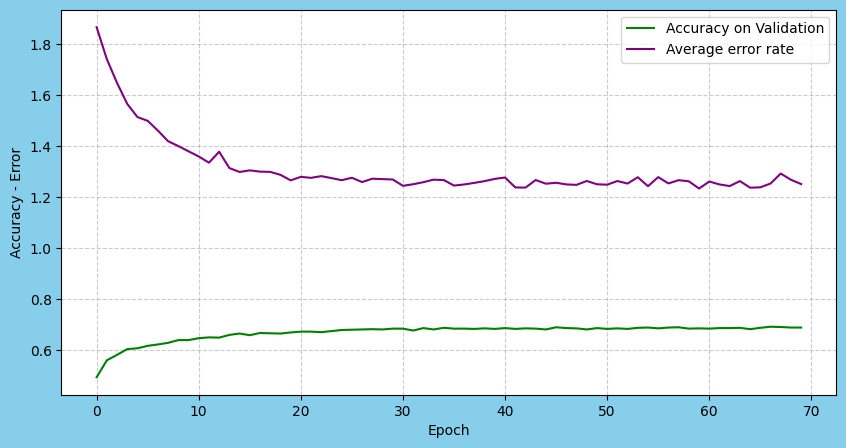

In [1272]:
some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.grid(linestyle = '--',c = 'gray',alpha = 0.4)
some_ax.plot(the_scores,c = 'green',label = 'Accuracy on Validation')
some_ax.plot(the_losses,color = 'purple',label  = 'Average error rate')
some_ax.set_ylabel('Accuracy - Error')
some_ax.set_xlabel('Epoch')
some_ax.legend()

In [1276]:
some_figure.savefig('/home/luchian/all_data/uni_data/val_48.png')

In [1177]:
ngram_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/ngram_100_embeddings.pth',weights_only = True))
ngramcnnmod = NgramCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=100,ker_sizes=[2,4,5])
ngramcnnmod.embed.weight = ngram_model.embed.weight
print(ngramcnnmod.embed)
ngramcnnmod.to(device = 'cuda')

Embedding(57568, 100, padding_idx=1)


NgramCNNMod(
  (embed): Embedding(57568, 100, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 100), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(4, 100), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(5, 100), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=942, stride=942, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

In [1178]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_loader = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=45)
epoch = 25
lr = 0.00005
optimizer = torch.optim.Adam(lr = lr,params = ngramcnnmod.parameters(),betas = (0.9,0.99))

In [1179]:
final_cnn_ngram_100 = train_classification_model(ngramcnnmod,epoch,train_loader,optimizer,loss_func,TestDataset,dev = 'cuda')

Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.12it/s]


Epoch # 1 | Loss: 1.899601865044007 | Val acc: 0.37408 | Best acc on epoch #1



Going through the loader: 100%|██████████| 520/520 [00:43<00:00, 12.04it/s]


Epoch # 2 | Loss: 1.817601461135424 | Val acc: 0.4315 | Best acc on epoch #2



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.46it/s]


Epoch # 3 | Loss: 1.7601632396762188 | Val acc: 0.4548 | Best acc on epoch #3



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.61it/s]


Epoch # 4 | Loss: 1.7186798946215556 | Val acc: 0.45139 | Best acc on epoch #3



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.29it/s]


Epoch # 5 | Loss: 1.6766660290268751 | Val acc: 0.46731 | Best acc on epoch #5



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.32it/s]


Epoch # 6 | Loss: 1.666257315644851 | Val acc: 0.45765 | Best acc on epoch #5



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.62it/s]


Epoch # 7 | Loss: 1.6337176936177107 | Val acc: 0.47243 | Best acc on epoch #7



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.30it/s]


Epoch # 8 | Loss: 1.5974375266295213 | Val acc: 0.47698 | Best acc on epoch #8



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.19it/s]


Epoch # 9 | Loss: 1.579207618190692 | Val acc: 0.47641 | Best acc on epoch #8



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.25it/s]


Epoch # 10 | Loss: 1.5791923078206869 | Val acc: 0.47527 | Best acc on epoch #8



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.36it/s]


Epoch # 11 | Loss: 1.5658939520900066 | Val acc: 0.47811 | Best acc on epoch #11



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.26it/s]


Epoch # 12 | Loss: 1.5525419179063578 | Val acc: 0.48039 | Best acc on epoch #12



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.27it/s]


Epoch # 13 | Loss: 1.4902894253914172 | Val acc: 0.47925 | Best acc on epoch #12



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.32it/s]


Epoch # 14 | Loss: 1.5104087794056305 | Val acc: 0.47925 | Best acc on epoch #12



Going through the loader: 100%|██████████| 520/520 [00:43<00:00, 12.08it/s]


Epoch # 15 | Loss: 1.4911682434953175 | Val acc: 0.47982 | Best acc on epoch #15



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.24it/s]


Epoch # 16 | Loss: 1.4871607064054562 | Val acc: 0.48209 | Best acc on epoch #16



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.18it/s]


Epoch # 17 | Loss: 1.4953259321359487 | Val acc: 0.48039 | Best acc on epoch #16



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.45it/s]


Epoch # 18 | Loss: 1.4827568783209875 | Val acc: 0.48152 | Best acc on epoch #18



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.33it/s]


Epoch # 19 | Loss: 1.4648281867687518 | Val acc: 0.4838 | Best acc on epoch #19



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.24it/s]


Epoch # 20 | Loss: 1.4748991367622064 | Val acc: 0.48266 | Best acc on epoch #19



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.20it/s]


Epoch # 21 | Loss: 1.4761326182347076 | Val acc: 0.4838 | Best acc on epoch #21



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.25it/s]


Epoch # 22 | Loss: 1.463422204554081 | Val acc: 0.48607 | Best acc on epoch #22



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.45it/s]


Epoch # 23 | Loss: 1.4445023076465497 | Val acc: 0.48493 | Best acc on epoch #22



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.47it/s]


Epoch # 24 | Loss: 1.449032515172775 | Val acc: 0.4855 | Best acc on epoch #24



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.46it/s]


Epoch # 25 | Loss: 1.4261510462141953 | Val acc: 0.48493 | Best acc on epoch #24



In [1277]:
the_losses = final_cnn_ngram_100[1]
the_scores = final_cnn_ngram_100[2]

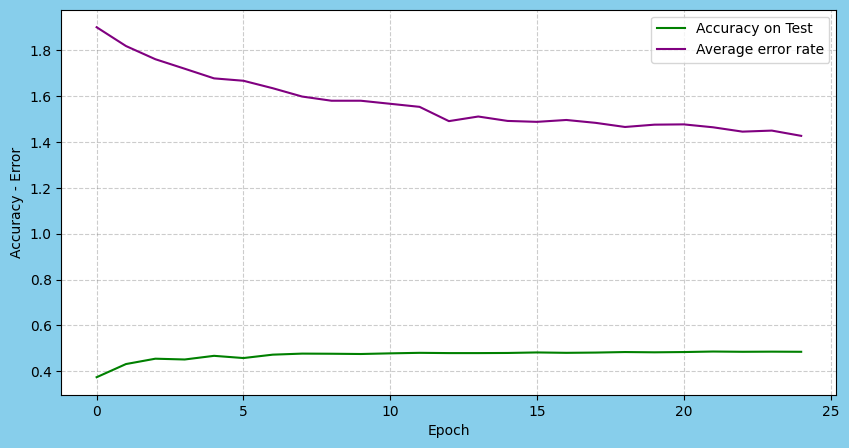

In [1278]:
some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.grid(linestyle = '--',c = 'gray',alpha = 0.4)
some_ax.plot(the_scores,c = 'green',label = 'Accuracy on Test')
some_ax.plot(the_losses,color = 'purple',label  = 'Average error rate')
some_ax.set_ylabel('Accuracy - Error')
some_ax.set_xlabel('Epoch')
some_ax.legend()

In [1279]:
some_figure.savefig('/home/luchian/all_data/uni_data/test_48.png')

In [ ]:
# torch.save(ngramcnnmod.state_dict(),'/home/luchian/all_data/uni_data/NgramCNNmod_acc_48.pth')
# ngramcnnmod.load_state_dict(torch.load('/home/luchian/all_data/uni_data/NgramCNNmod_acc_48.pth',weights_only=True))

<All keys matched successfully>

In [ ]:
# get_accuracy(ngramcnnmod,TestDataset)

0.48493

In [ ]:
##############################################RECAP
#CBOW
#NGRAM
#GloVe
#300 embedding dimension 

далее представленый ячейки в которых некотрые данные снова загружаются для удобства загрузки

также там представлены модели cbow и glove

In [3]:
#DATASETS CLASSES

#Embedding Datasest
class NGramDataset(Dataset):
    def __init__(self,tokenizer,the_data):
        self.main_data = the_data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.main_data)
    
    def __getitem__(self,indx):
        X = torch.tensor([self.tokenizer.token_to_id(word) if self.tokenizer.token_to_id(word) != None else self.tokenizer.token_to_id('[UNK]') for word in self.main_data[indx][0]],dtype=torch.long)
        true_word = self.main_data[indx][1]
        y = self.tokenizer.token_to_id(true_word) if self.tokenizer.token_to_id(true_word) != None else self.tokenizer.token_to_id('[UNK]')
        return X,y
    
#News Dataset
class NewsDataset(Dataset):
    def __init__(self,the_data,le,tokenizer,transforms = None):
        self.main_data = the_data
        self.tokenizer = tokenizer
        self.label_encoder = le
        self.transforms = transforms

    def __len__(self):
        return len(self.main_data)
    
    def __getitem__(self,indx):
        X = [self.tokenizer.token_to_id(one_token) if self.tokenizer.token_to_id(one_token) != None else self.tokenizer.token_to_id('[UNK]') for one_token in normalize_text(self.main_data.iloc[indx,0])]
        y = self.label_encoder.transform([self.main_data.iloc[indx,1]]).item()
        X,y = torch.tensor(X,dtype = torch.long),torch.tensor(y,dtype = torch.long)
        return (X,y) if self.transforms == None else (self.transforms(X),y)

In [6]:
#DIFFERENT MODELS


#EmbedCNNMod
class EmbedCNNMod(nn.Module):
    def __init__(self,vocab_size,dim_embed = 300,ker_sizes = [2,4,5]):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed,padding_idx=1)
        self.conv1 = nn.Conv2d(1,111,kernel_size=(ker_sizes[0],dim_embed))
        self.conv2 = nn.Conv2d(1,111,kernel_size=(ker_sizes[1],dim_embed))
        self.conv3 = nn.Conv2d(1,111,kernel_size=(ker_sizes[2],dim_embed))
        self.lin1 = nn.Linear(333,7)

        self.mp1 = nn.MaxPool1d(kernel_size=945-ker_sizes[0]+1)
        self.mp2 = nn.MaxPool1d(kernel_size=945-ker_sizes[1]+1)
        self.mp3 = nn.MaxPool1d(kernel_size=945-ker_sizes[2]+1)
        self.drop = nn.Dropout1d(p = 0.5)

        self.rel = nn.ReLU()

    def forward(self,inds_list):
        y = self.embed(inds_list)
        if len(y.size()) == 3:
            y = y.unsqueeze(dim = 1)
        else:
            y = y.unsqueeze(dim = 0)
            y = y.unsqueeze(dim = 0)

        y1 = self.rel(self.conv1(y))
        y2 = self.rel(self.conv2(y))
        y3 = self.rel(self.conv3(y))

        y1 = y1.squeeze(dim = -1)
        y2 = y2.squeeze(dim = -1)
        y3 = y3.squeeze(dim = -1)
        
        y1 = self.mp1(y1)
        y2 = self.mp2(y2)
        y3 = self.mp3(y3)

        y = torch.concat([y1,y2,y3],dim = -1)
        y = y.reshape(y.shape[0],-1)
        y = self.drop(y)
        y = self.rel(self.lin1(y))
        return y


#ngram model 
class NGramModel(nn.Module):
    def __init__(self,vocab_size,dim_embed,window_size = 2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed)
        #from both sides
        self.linear1 = nn.Linear(2*window_size*dim_embed,128)
        self.linear2 = nn.Linear(128,vocab_size)
        self.rel = nn.ReLU()

    def forward(self,ind_list):
        y = self.embed(ind_list)
        y = y.reshape(y.shape[0],-1)
        y = self.rel(self.linear1(y))
        y = self.rel(self.linear2(y))
        return y
    
#CBOW model 
class CBOWModel(nn.Module):
    def __init__(self,vocab_size,dim_embed,window_size = 2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed)
        self.linear1 = nn.Linear(dim_embed,128)
        self.linear2 = nn.Linear(128,vocab_size)
        self.rel = nn.ReLU()

    def forward(self,ind_list):
        y = self.embed(ind_list).sum(dim = 1)
        y = self.rel(self.linear1(y))
        y = self.rel(self.linear2(y))
        return y
    
#GloVe model
class GloveModel(nn.Module):
    def __init__(self,vocab_size,embed_dim = 150,dev = 'cuda'):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx = 1)
        self.bias = torch.randn(1).to(device = dev)

    def forward(self,inds_tensor):
        ind1 = inds_tensor[:1]
        ind2 = inds_tensor[1:]
        vec1 = self.embed(ind1).reshape(-1)
        vec2 = self.embed(ind2).reshape(-1)
        return vec1.dot(vec2) + self.bias

In [4]:
#MAIN FUNCTIONS






#function that prints losses and val scores
def print_loss_val(the_losses,the_vals,val_name = 'Validation'):
    some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
    some_ax = some_figure.add_subplot()
    some_ax.grid(linestyle = '--',c = 'gray',alpha = 0.4)
    some_ax.plot(the_vals,c = 'green',label = 'Accuracy on ' + val_name)
    some_ax.plot(the_losses,color = 'purple',label  = 'Average error rate')
    some_ax.set_ylabel('Accuracy - Error')
    some_ax.set_xlabel('Epoch')
    some_ax.legend()
    return some_figure

#function for training the classification model
def train_classification_model(the_model,epoch,loader,optimizer,loss_func,val_dataset,dev = 'cuda'):
    average_ep_losses = []
    best_epoch = None
    val_accs = []
    try:
        for one_ep in range(epoch):
            the_model.train()
            the_losses = []
            for X,y in tqdm(loader,desc = 'Going through the loader'):
                X,y = X.to(device = dev),y.to(device = dev)
                optimizer.zero_grad()
                y_pred = the_model(X)
                the_loss = loss_func(y_pred,y)
                the_loss.backward()
                the_losses.append(the_loss.item())
                optimizer.step()
            if one_ep%1== 0:
                avg_loss = np.array(the_losses).mean()
                average_ep_losses.append(avg_loss)
                val_score = get_accuracy(the_model,val_dataset,dev =dev)
                val_accs.append(val_score)

                if best_epoch == None:
                    best_epoch = one_ep + 1
                else:
                    best_epoch = one_ep + 1 if val_accs[-1] > val_accs[-2] else best_epoch

                print(f'Epoch # {one_ep+1} | Loss: {avg_loss} | Val acc: {val_score} | Best acc on epoch #{best_epoch}',end = '\n\n')
        return best_epoch,average_ep_losses,val_accs
    except KeyboardInterrupt:
        return best_epoch,average_ep_losses,val_accs

def train_ngram_model(the_model,epoch,loader,optimizer,loss_func,dev = 'cuda',save_path = '1'):
    for one_ep in range(epoch):
        torch.save(the_model.state_dict(),save_path)
        the_model.train()
        the_losses = []
        for X,y in tqdm(loader,desc = 'Going through the loader'):
            X,y = X.to(device = 'cuda'),y.to(device = 'cuda')
            optimizer.zero_grad()
            y_pred = the_model(X)
            the_loss = loss_func(y_pred,y)
            the_loss.backward()
            the_losses.append(the_loss.item())
            optimizer.step()
        if one_ep%1== 0:
            print(f'Current Loss: {np.array(the_losses).mean()}')

def train_cbow_model(the_model,epoch,loader,optimizer,loss_func,dev = 'cuda'):
    for one_ep in range(epoch):
        the_model.train()
        the_losses = []
        for X,y in tqdm(loader,desc = 'Going through the loader'):
            X,y = X.to(device = 'cuda'),y.to(device = 'cuda')
            optimizer.zero_grad()
            y_pred = the_model(X)
            the_loss = loss_func(y_pred,y)
            the_loss.backward()
            the_losses.append(the_loss.item())
            optimizer.step()
        if one_ep%1== 0:
            print(f'Current Loss: {np.array(the_losses).mean()}')

class Padding():
    def __init__(self,pad = 945,dtype = torch.long,dev = 'cpu'):
        self.pad = pad
        self.dtype = dtype
        self.dev = dev
    def __call__(self,tens):
        ones = torch.ones(self.pad,dtype = self.dtype).to(device = self.dev)
        for ind in range(tens.shape[0]):
            ones[ind] = tens[ind]
        return ones
    
#accuracy score
@torch.no_grad()
def get_accuracy(model,dataset,dev = 'cuda'):
    model.eval()
    model.to(device = dev)

    N = len(dataset)
    correct = 0

    the_loader = DataLoader(dataset = dataset,shuffle=True,batch_size=1)
    for X,y in the_loader:
        X,y = X.to(device= dev),y.to(device= dev)
        y_pred = model(X).softmax(dim = 1).argmax(dim = 1).item()
        y = y.item()
        if y == y_pred:
            correct += 1
    return round(correct/N,5)


#text normalization
def normalize_text(the_text):
    lowered = the_text.lower()
    found = re.findall(r'[А-я0-9A-z]+',lowered)
    filtered_found = [word for word in found if word != '' and word not in russian_stopwords]
    return filtered_found


def cleared_texts(text_col):
    for ith_row in range(len(text_col)):
        for token in normalize_text(text_col.iloc[ith_row]):
            yield token


russian_stopwords = stopwords.words('russian')
print(len(russian_stopwords))
russian_stopwords[:10]

151


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [7]:
#LOADING

#some variables that need to be saved
the_max_len_of_sents = 945

#loading saved tokenizers

with open('Train_tokenizer.pkl','rb') as file:
    Train_tokenizer = pickle.load(file)

with open('Test_tokenizer.pkl','rb') as file:
    Test_tokenizer = pickle.load(file)

#loading datasets
Train_news,Test_news = pd.read_csv('Train_news.csv',index_col=0),pd.read_csv('Test_news.csv',index_col=0)

#load dataset for ngram and cbow models
with open('/home/luchian/all_data/uni_data/Train_Ngramsdataset','rb') as file:
    Train_Ngramsdataset = pickle.load(file)

#loading labels
unique_train_labels = Train_news['topic'].unique()
le = preprocessing.LabelEncoder().fit(unique_train_labels)
print(le.classes_)

#loading torhch datasets
TrainDataset = NewsDataset(Train_news,le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))
TestDataset = NewsDataset(Test_news,le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))

#computing classes
the_classes = []
for X,y in TrainDataset:
    the_classes.append(int(y))

#Train and Validation
MainTrain,MainVal = random_split(TrainDataset,lengths=[0.96,0.04])
print(len(MainTrain),len(MainVal))

the_weights = compute_class_weight(class_weight= 'balanced',classes=np.unique(the_classes),y=np.array(the_classes))
scaled_weights = the_weights/the_weights.sum()
torch_train_weights = torch.tensor(scaled_weights,dtype = torch.float32)
print(torch_train_weights)


#embeddings models
vocab_size = Train_tokenizer.get_vocab_size()
ngram_model = NGramModel(vocab_size,dim_embed = 300,window_size = 2)


#TRAINING Glove Model 
vocab_size = Train_tokenizer.get_vocab_size()
glove_mod = GloveModel(vocab_size,embed_dim = 150)
glove_mod.to(device = 'cuda')


['Бизнес' 'Интернет и СМИ' 'Культура' 'Политика' 'Спорт' 'Финансы'
 'Экономика']
22430 934
tensor([0.2881, 0.0106, 0.0111, 0.3776, 0.0111, 0.2908, 0.0107])


GloveModel(
  (embed): Embedding(57568, 150, padding_idx=1)
)

создаем модель ngram но уже с размерность 300 (полное обучения смотреть в ноутбуке goolge_grain.ipynb)

In [74]:
#TRAINING NGRAM model 
vocab_size = Train_tokenizer.get_vocab_size()
ngram_model = NGramModel(vocab_size,dim_embed = 300,window_size = 2)
ngram_model.to(device = 'cuda')

NGramModel(
  (embed): Embedding(57568, 300)
  (linear1): Linear(in_features=1200, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=57568, bias=True)
  (rel): ReLU()
)

In [15]:
train_loader_ngram_300 = DataLoader(dataset = Train_Ngramsdataset,shuffle = True,batch_size = 24)
lr = 0.002
epoch = 50
optimizer_ngram_300 = torch.optim.SGD(lr = lr,params= ngram_model.parameters(),momentum=0.3)
the_loss = nn.CrossEntropyLoss()

In [ ]:
#the model was trained in google colab
train_ngram_model(ngram_model,epoch,train_loader_ngram_300,optimizer_ngram_300,the_loss,dev = 'cuda',save_path='/home/luchian/all_data/uni_data/ngram_300_embeddings.pth')

Going through the loader: 100%|██████████| 131403/131403 [52:20<00:00, 41.84it/s]  


Current Loss: 9.59820879176584


Going through the loader: 100%|██████████| 131403/131403 [1:46:07<00:00, 20.64it/s]  


Current Loss: 8.753965046482305


Going through the loader: 100%|██████████| 131403/131403 [1:57:13<00:00, 18.68it/s]  


Current Loss: 8.484169470494848


Going through the loader:  55%|█████▍    | 71905/131403 [1:23:35<1:09:09, 14.34it/s]


KeyboardInterrupt: 

In [29]:
ngram_model.embed.weight

Parameter containing:
tensor([[ 1.4625, -2.8590, -0.2006,  ...,  0.0446,  0.1728,  0.1914],
        [ 0.6954, -0.7205,  1.4831,  ...,  0.7945, -0.1423,  1.7137],
        [-0.4005,  2.2723, -0.0741,  ..., -0.7002,  0.2441, -0.3373],
        ...,
        [-0.5664, -0.0742,  1.0343,  ..., -0.6893,  2.0791,  1.2044],
        [-0.4950,  0.5707,  1.4642,  ..., -1.8228, -0.6479, -2.0907],
        [ 1.9204,  0.7842,  1.4448,  ..., -1.3439,  0.3315,  0.1267]],
       device='cuda:0', requires_grad=True)

In [ ]:
# torch.save(ngram_model.state_dict(),'/home/luchian/all_data/uni_data/ngram_300_embeddings.pth')
# torch.save(optimizer_ngram_300.state_dict(),'/home/luchian/all_data/uni_data/optimizer_ngram_300.pth')
# optimizer_ngram_300.load_state_dict(torch.load('/home/luchian/all_data/uni_data/optimizer_ngram_300.pth',weights_only=True))
# ngram_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/ngram_300_embeddings.pth',weights_only=True))

<All keys matched successfully>

In [132]:
ngram_300_cnn_mod = EmbedCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=300,ker_sizes=[2,4,5])
ngram_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/ngram_300_embeddings_epoch#9.pth',weights_only=True))
ngram_300_cnn_mod.embed.weight = ngram_model.embed.weight
ngram_300_cnn_mod.to(device = 'cuda')

EmbedCNNMod(
  (embed): Embedding(57568, 300, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 300), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(4, 300), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(5, 300), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=942, stride=942, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

In [37]:
torch_train_weights

tensor([0.2881, 0.0106, 0.0111, 0.3776, 0.0111, 0.2908, 0.0107])

In [60]:
MainTrain,MainVal = random_split(TrainDataset,lengths=[0.9,0.1])
print(len(MainTrain),len(MainVal))

21028 2336


In [61]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_loader_val_ngram_cnn = DataLoader(dataset = MainTrain,shuffle=True,batch_size=35)
epoch = 50
lr = 0.00005
optimizer_val_ngram_cnn = torch.optim.Adam(lr = lr,params = ngram_300_cnn_mod.parameters(),betas = (0.9,0.99))

In [ ]:
res_300 = train_classification_model(ngram_300_cnn_mod,epoch,train_loader_val_ngram_cnn,optimizer_val_ngram_cnn,loss_func,MainVal,dev = 'cuda')

Going through the loader: 100%|██████████| 641/641 [01:24<00:00,  7.57it/s]


Epoch # 1 | Loss: 1.8861202682236242 | Val acc: 0.39507 | Best acc on epoch #1



Going through the loader: 100%|██████████| 641/641 [01:24<00:00,  7.60it/s]


Epoch # 2 | Loss: 1.77881420207284 | Val acc: 0.42934 | Best acc on epoch #2



Going through the loader: 100%|██████████| 641/641 [01:24<00:00,  7.55it/s]


Epoch # 3 | Loss: 1.6857086637648704 | Val acc: 0.44004 | Best acc on epoch #3



Going through the loader: 100%|██████████| 641/641 [01:25<00:00,  7.46it/s]


Epoch # 4 | Loss: 1.6190637604866682 | Val acc: 0.45396 | Best acc on epoch #4



Going through the loader:  30%|██▉       | 191/641 [01:35<03:45,  1.99it/s]


In [133]:
#the model was trained in google colab
ngram_300_cnn_mod.load_state_dict(torch.load('ngram_300_cnn_mod_epoch#20.pth',weights_only=True))

<All keys matched successfully>

In [ ]:
#TRAINING THE CBOW MODEL  the model was trained in google colab
vocab_size = Train_tokenizer.get_vocab_size()
cbow_model = CBOWModel(vocab_size,dim_embed = 300,window_size = 2)
cbow_model.to(device = 'cuda')

In [251]:
#the model was trained in google colab
ngram_300_cnn_mod.load_state_dict(torch.load('cbow_300_cnn_mod_epoch#13.pth',weights_only=True))

<All keys matched successfully>

более менее нормальный результат для сверточной модели

In [134]:
get_accuracy(ngram_300_cnn_mod,dataset=TestDataset,dev = 'cuda')

0.71291

In [ ]:
#for CBOW model
get_accuracy(ngram_300_cnn_mod,dataset=TestDataset,dev = 'cuda')

0.7021

In [30]:
def get_context_docs(the_series,context_window):
    docs  = []
    for one_text in the_series:
        normal = normalize_text(one_text)
        N = len(normal)
        if N >= 2*context_window + 1:
            for ind in range(context_window,N-context_window):
                docs.append(' '.join(normal[ind-context_window:ind+context_window]))
    return docs

In [31]:
docs_for_freqs = get_context_docs(Train_news['Text'],context_window = 10)
len(docs_for_freqs)

2690373

In [32]:
vectorizer = CountVectorizer(token_pattern=r'[^\s]+')
vectorizer

CountVectorizer(token_pattern='[^\\s]+')

In [33]:
X_count = vectorizer.fit_transform(docs_for_freqs)

In [34]:
freq_matrix = X_count.T@X_count 

In [35]:
freq_matrix

<Compressed Sparse Column sparse matrix of dtype 'int64'
	with 61030179 stored elements and shape (203323, 203323)>

In [36]:
features = vectorizer.get_feature_names_out()
features[33235:333393]

array(['благодарностей', 'благодарности', 'благодарность', ..., 'ящура',
       'ящуре', 'ящуром'], dtype=object)

In [37]:
feature_dict = {features[k]:k for k in range(len(features))}

In [38]:
dict_cont_words = dict()
ind = 0
for cont in tqdm(docs_for_freqs):
    for word in cont.strip().split(' '):
        dict_cont_words[word] = ind
        ind += 1

100%|██████████| 2690373/2690373 [00:09<00:00, 285366.36it/s]


In [39]:
cont_words_in_order = list(dict_cont_words.keys())

In [40]:
#train GloVe model
def glove_dataset(words,context_window = 10):
        for ind1 in range(len(words)-2*context_window):
            for ind2 in range(ind1,ind1+2*context_window):
                word1 = words[ind1]
                word2 = words[ind2]
                tok_ind1 = Train_tokenizer.token_to_id(word1)
                tok_ind2 = Train_tokenizer.token_to_id(word2)
                tok_values = torch.tensor([tok_ind1 if tok_ind1 != None else Train_tokenizer.token_to_id('[UNK]'),tok_ind2 if tok_ind2 != None else Train_tokenizer.token_to_id('[UNK]')])
                freq_value = freq_matrix[feature_dict[word1],feature_dict[word2]]
                yield tok_values,freq_value
                 

In [41]:
dataset = glove_dataset(cont_words_in_order)
dataset

<generator object glove_dataset at 0x70b622d34fb0>

In [42]:
from time import perf_counter

t0 = perf_counter()
one  = 1
for one_sample in dataset:
    1

t1 = perf_counter()
print(f"Execution took {t1 - t0:.8f} seconds")

Execution took 60.29656666 seconds


In [31]:
class GloveModel(nn.Module):
    def __init__(self,vocab_size,embed_dim = 150,dev = 'cuda'):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx = 1)
        self.bias = torch.randn(1).to(device = dev)

    def forward(self,inds_tensor):
        ind1 = inds_tensor[:1]
        ind2 = inds_tensor[1:]
        vec1 = self.embed(ind1).reshape(-1)
        vec2 = self.embed(ind2).reshape(-1)
        return vec1.dot(vec2) + self.bias

In [44]:
def weight_func(x,alpha = 3/4,x_max = 100):
    return (x/x_max)**alpha if x < x_max else 1

аналогично обучаем модель векторных представлений glove (подробнгее смотреть в аналитической записке)

In [45]:
#TRAINING THE GLOVE MODEL
def train_glove_model(the_model,epoch,optimizer,batch_size = 2000):
    epoch_losses = []
    for ep in tqdm(range(epoch)):
        glove_data = glove_dataset(cont_words_in_order)

        count = 0
        batch_losses = []
        the_loss = 0

        for X,y in glove_data:
            count += 1
            X,y = X.to(device = 'cuda'),torch.tensor(y)
            y_pred = the_model(X)
            the_loss += weight_func(y)*(y_pred-torch.log(1+y))**2
            if count == batch_size:
                the_loss = the_loss/count
                optimizer.zero_grad()
                the_loss.backward()
                optimizer.step()

                batch_losses.append(round(the_loss.item(),5))
                print(f'Current_batch_loss: {batch_losses[-1]}')
                count,the_loss = 0,0

        epoch_losses.append(round(sum(batch_losses)/len(batch_losses),5))                                                                                                                   
        print(f'Epoch #{ep+1} | Loss: {epoch_losses[-1]}')
    return epoch_losses

In [11]:
#TRAINING Glove Model 
vocab_size = Train_tokenizer.get_vocab_size()
glove_mod = GloveModel(vocab_size,embed_dim = 150)
glove_mod.to(device = 'cuda')

GloveModel(
  (embed): Embedding(57568, 150, padding_idx=1)
)

In [50]:
epoch = 30
lr = 0.001
optimizer = torch.optim.SGD(glove_mod.parameters(),lr = lr,momentum = 0.25)

In [51]:
losses_of_glove_model = train_glove_model(glove_mod,epoch,optimizer)

  0%|          | 0/30 [00:00<?, ?it/s]

Current_batch_loss: 1080.91602
Current_batch_loss: 1065.20007
Current_batch_loss: 1116.8429
Current_batch_loss: 1074.82983
Current_batch_loss: 1094.55798
Current_batch_loss: 1071.53796
Current_batch_loss: 1084.45752
Current_batch_loss: 1033.94348
Current_batch_loss: 1021.28461
Current_batch_loss: 1168.81372
Current_batch_loss: 1083.32605
Current_batch_loss: 1049.55676
Current_batch_loss: 1104.68298
Current_batch_loss: 1124.02393
Current_batch_loss: 1098.63525
Current_batch_loss: 1036.30396
Current_batch_loss: 1063.91687
Current_batch_loss: 1077.20691
Current_batch_loss: 1074.6853
Current_batch_loss: 989.42993
Current_batch_loss: 1044.04626
Current_batch_loss: 1094.26917
Current_batch_loss: 1063.41589
Current_batch_loss: 1018.3913
Current_batch_loss: 1051.63086
Current_batch_loss: 1020.46454
Current_batch_loss: 1010.55573
Current_batch_loss: 959.34668
Current_batch_loss: 1004.01965
Current_batch_loss: 1013.87982
Current_batch_loss: 1034.73682
Current_batch_loss: 973.00208
Current_batch_

  3%|▎         | 1/30 [2:00:37<58:18:18, 7237.86s/it]

Current_batch_loss: 0.03363
Epoch #1 | Loss: 305.93445
Current_batch_loss: 1043.64624
Current_batch_loss: 984.08398
Current_batch_loss: 905.46088
Current_batch_loss: 1000.42682
Current_batch_loss: 1050.29456
Current_batch_loss: 944.00891
Current_batch_loss: 1006.75024
Current_batch_loss: 950.53937
Current_batch_loss: 898.73578
Current_batch_loss: 808.61267
Current_batch_loss: 1016.75659
Current_batch_loss: 943.31726
Current_batch_loss: 911.22229
Current_batch_loss: 895.33551
Current_batch_loss: 961.39771
Current_batch_loss: 950.77045
Current_batch_loss: 1034.05139
Current_batch_loss: 976.70477
Current_batch_loss: 910.37878
Current_batch_loss: 944.24518
Current_batch_loss: 996.86432
Current_batch_loss: 1039.28809
Current_batch_loss: 1043.17896
Current_batch_loss: 988.28741
Current_batch_loss: 1006.1615
Current_batch_loss: 963.9248
Current_batch_loss: 847.99585
Current_batch_loss: 882.40314
Current_batch_loss: 931.89026
Current_batch_loss: 883.41455
Current_batch_loss: 977.09021
Current_

  7%|▋         | 2/30 [4:01:08<56:15:41, 7233.62s/it]

Current_batch_loss: 0.00916
Epoch #2 | Loss: 298.06526
Current_batch_loss: 1041.82056
Current_batch_loss: 982.36932
Current_batch_loss: 903.89032
Current_batch_loss: 998.6897
Current_batch_loss: 1048.46838
Current_batch_loss: 942.36688
Current_batch_loss: 1004.98523
Current_batch_loss: 948.94238
Current_batch_loss: 897.20862
Current_batch_loss: 807.19409
Current_batch_loss: 1014.98145
Current_batch_loss: 941.69696
Current_batch_loss: 909.64447
Current_batch_loss: 893.77643
Current_batch_loss: 959.74585
Current_batch_loss: 949.13867
Current_batch_loss: 1032.26111
Current_batch_loss: 975.0022
Current_batch_loss: 908.79645
Current_batch_loss: 942.68585
Current_batch_loss: 995.14221
Current_batch_loss: 1037.47351
Current_batch_loss: 1041.38452
Current_batch_loss: 986.63013
Current_batch_loss: 1004.42773
Current_batch_loss: 962.30731
Current_batch_loss: 846.57275
Current_batch_loss: 880.95752
Current_batch_loss: 930.34045
Current_batch_loss: 881.94586
Current_batch_loss: 975.4408
Current_ba

 10%|█         | 3/30 [6:01:40<54:14:49, 7232.94s/it]

Current_batch_loss: 0.00748
Epoch #3 | Loss: 297.57196
Current_batch_loss: 1040.00598
Current_batch_loss: 980.67041
Current_batch_loss: 902.35211
Current_batch_loss: 996.96838
Current_batch_loss: 1046.65271
Current_batch_loss: 940.74744
Current_batch_loss: 1003.23389
Current_batch_loss: 947.36249
Current_batch_loss: 895.70532
Current_batch_loss: 805.82617
Current_batch_loss: 1013.22186
Current_batch_loss: 940.10199
Current_batch_loss: 908.09497
Current_batch_loss: 892.25006
Current_batch_loss: 958.10992
Current_batch_loss: 947.53131
Current_batch_loss: 1030.47852
Current_batch_loss: 973.31982
Current_batch_loss: 907.24078
Current_batch_loss: 941.13812
Current_batch_loss: 993.43665
Current_batch_loss: 1035.67456
Current_batch_loss: 1039.6012
Current_batch_loss: 984.9826
Current_batch_loss: 1002.70642
Current_batch_loss: 960.70184
Current_batch_loss: 845.1731
Current_batch_loss: 879.52563
Current_batch_loss: 928.80267
Current_batch_loss: 880.49731
Current_batch_loss: 973.80243
Current_ba

 13%|█▎        | 4/30 [8:02:15<52:14:37, 7233.75s/it]

Current_batch_loss: 0.00724
Epoch #4 | Loss: 297.08622
Current_batch_loss: 1038.198
Current_batch_loss: 978.97961
Current_batch_loss: 900.82178
Current_batch_loss: 995.25458
Current_batch_loss: 1044.84583
Current_batch_loss: 939.13409
Current_batch_loss: 1001.48804
Current_batch_loss: 945.78723
Current_batch_loss: 894.20941
Current_batch_loss: 804.46832
Current_batch_loss: 1011.46716
Current_batch_loss: 938.51355
Current_batch_loss: 906.55328
Current_batch_loss: 890.73206
Current_batch_loss: 956.48212
Current_batch_loss: 945.9314
Current_batch_loss: 1028.70215
Current_batch_loss: 971.64465
Current_batch_loss: 905.69269
Current_batch_loss: 939.59607
Current_batch_loss: 991.73816
Current_batch_loss: 1033.88184
Current_batch_loss: 1037.82092
Current_batch_loss: 983.34039
Current_batch_loss: 1000.99237
Current_batch_loss: 959.10187
Current_batch_loss: 843.77997
Current_batch_loss: 878.09888
Current_batch_loss: 927.27026
Current_batch_loss: 879.05389
Current_batch_loss: 972.16937
Current_ba

 13%|█▎        | 4/30 [8:45:49<56:57:49, 7887.29s/it]


KeyboardInterrupt: 

In [ ]:
# torch.save(glove_mod.state_dict(),'/home/luchian/all_data/uni_data/glove_model_weights.pth')

In [ ]:
# glove_mod.load_state_dict(torch.load('/home/luchian/all_data/uni_data/glove_model_weights.pth',weights_only=True))

<All keys matched successfully>

In [13]:
#train cnn model with glove vectors
glove_150_cnn_mod = EmbedCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=150,ker_sizes=[2,4,5])
glove_mod.load_state_dict(torch.load('/home/luchian/all_data/uni_data/glove_model_weights.pth',weights_only=True))
glove_150_cnn_mod.embed.weight = glove_mod.embed.weight
glove_150_cnn_mod.to(device = 'cuda')

EmbedCNNMod(
  (embed): Embedding(57568, 150, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 150), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(4, 150), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(5, 150), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=942, stride=942, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

In [67]:
MainTrain,MainVal = random_split(TrainDataset,lengths=[0.9,0.1])
print(len(MainTrain),len(MainVal))

21028 2336


In [68]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_loader_val_glove_cnn = DataLoader(dataset = MainTrain,shuffle=True,batch_size=35)
epoch = 30
lr = 0.00005
optimizer_glove_cnn = torch.optim.Adam(lr = lr,params = glove_150_cnn_mod.parameters(),betas = (0.9,0.99))

обучаем сверточную модель на векторных прествавлениях glove    
также для модели cbow поллное обкчение представлено в google_train.ipynb

In [ ]:
#time: 24 minutes
cnn_glove_res = train_classification_model(glove_150_cnn_mod,
                                           epoch,
                                           train_loader_val_glove_cnn,
                                           optimizer_glove_cnn,
                                           loss_func,
                                           MainVal,
                                           dev = 'cuda')

Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.53it/s]


Epoch # 1 | Loss: 1.915160243007387 | Val acc: 0.42937 | Best acc on epoch #1



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.48it/s]


Epoch # 2 | Loss: 1.813440762819744 | Val acc: 0.52483 | Best acc on epoch #2



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.64it/s]


Epoch # 3 | Loss: 1.7371219162536342 | Val acc: 0.58604 | Best acc on epoch #3



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.58it/s]


Epoch # 4 | Loss: 1.6462238685858626 | Val acc: 0.61002 | Best acc on epoch #4



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.39it/s]


Epoch # 5 | Loss: 1.581516339755098 | Val acc: 0.625 | Best acc on epoch #5



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.49it/s]


Epoch # 6 | Loss: 1.52174074231289 | Val acc: 0.62928 | Best acc on epoch #6



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.59it/s]


Epoch # 7 | Loss: 1.4862695725110922 | Val acc: 0.65068 | Best acc on epoch #7



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.70it/s]


Epoch # 8 | Loss: 1.4556876242458325 | Val acc: 0.65668 | Best acc on epoch #8



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 9 | Loss: 1.4268412114478983 | Val acc: 0.66182 | Best acc on epoch #9



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.79it/s]


Epoch # 10 | Loss: 1.4107145033342865 | Val acc: 0.66524 | Best acc on epoch #10



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.58it/s]


Epoch # 11 | Loss: 1.3771178477417412 | Val acc: 0.67038 | Best acc on epoch #11



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.80it/s]


Epoch # 12 | Loss: 1.3563187094575753 | Val acc: 0.67295 | Best acc on epoch #12



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.76it/s]


Epoch # 13 | Loss: 1.3637293149250715 | Val acc: 0.6768 | Best acc on epoch #13



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.66it/s]


Epoch # 14 | Loss: 1.33865911190006 | Val acc: 0.67551 | Best acc on epoch #13



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.63it/s]


Epoch # 15 | Loss: 1.319054201170926 | Val acc: 0.67851 | Best acc on epoch #15



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.68it/s]


Epoch # 16 | Loss: 1.307553712272406 | Val acc: 0.68151 | Best acc on epoch #16



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.75it/s]


Epoch # 17 | Loss: 1.308659553131129 | Val acc: 0.6845 | Best acc on epoch #17



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.76it/s]


Epoch # 18 | Loss: 1.2837031373069212 | Val acc: 0.68878 | Best acc on epoch #18



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.89it/s]


Epoch # 19 | Loss: 1.285470471505119 | Val acc: 0.6905 | Best acc on epoch #19



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.80it/s]


Epoch # 20 | Loss: 1.303606267776743 | Val acc: 0.68836 | Best acc on epoch #19



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.71it/s]


Epoch # 21 | Loss: 1.2533936843201643 | Val acc: 0.69178 | Best acc on epoch #21



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.80it/s]


Epoch # 22 | Loss: 1.2383903763357693 | Val acc: 0.69349 | Best acc on epoch #22



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.79it/s]


Epoch # 23 | Loss: 1.2108402847747834 | Val acc: 0.69692 | Best acc on epoch #23



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.78it/s]


Epoch # 24 | Loss: 1.1983564999853316 | Val acc: 0.69563 | Best acc on epoch #23



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.78it/s]


Epoch # 25 | Loss: 1.1837558171614235 | Val acc: 0.69949 | Best acc on epoch #25



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.82it/s]


Epoch # 26 | Loss: 1.1849734649285302 | Val acc: 0.69777 | Best acc on epoch #25



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.81it/s]


Epoch # 27 | Loss: 1.1684637786495111 | Val acc: 0.69906 | Best acc on epoch #27



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.81it/s]


Epoch # 28 | Loss: 1.1693391589178221 | Val acc: 0.70163 | Best acc on epoch #28



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.83it/s]


Epoch # 29 | Loss: 1.1767322582234558 | Val acc: 0.69949 | Best acc on epoch #28



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.81it/s]


Epoch # 30 | Loss: 1.1591952266094094 | Val acc: 0.70077 | Best acc on epoch #30



In [70]:
#time
cnn_glove_res_2 = train_classification_model(glove_150_cnn_mod,
                                           50,
                                           train_loader_val_glove_cnn,
                                           optimizer_glove_cnn,
                                           loss_func,
                                           MainVal,
                                           dev = 'cuda')

Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.69it/s]


Epoch # 1 | Loss: 1.1740581328777624 | Val acc: 0.70462 | Best acc on epoch #1



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.69it/s]


Epoch # 2 | Loss: 1.1621838998477194 | Val acc: 0.70462 | Best acc on epoch #1



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.69it/s]


Epoch # 3 | Loss: 1.1626287326836546 | Val acc: 0.70548 | Best acc on epoch #3



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.70it/s]


Epoch # 4 | Loss: 1.1662661880998564 | Val acc: 0.70676 | Best acc on epoch #4



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.72it/s]


Epoch # 5 | Loss: 1.154011960979706 | Val acc: 0.70634 | Best acc on epoch #4



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.69it/s]


Epoch # 6 | Loss: 1.1827252082737432 | Val acc: 0.70719 | Best acc on epoch #6



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.57it/s]


Epoch # 7 | Loss: 1.1711817768568207 | Val acc: 0.70548 | Best acc on epoch #6



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.66it/s]


Epoch # 8 | Loss: 1.1570361185192863 | Val acc: 0.70548 | Best acc on epoch #6



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.71it/s]


Epoch # 9 | Loss: 1.1527714481617568 | Val acc: 0.70719 | Best acc on epoch #9



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.71it/s]


Epoch # 10 | Loss: 1.167231215018401 | Val acc: 0.70676 | Best acc on epoch #9



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.47it/s]


Epoch # 11 | Loss: 1.1402608799359168 | Val acc: 0.7089 | Best acc on epoch #11



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.63it/s]


Epoch # 12 | Loss: 1.1545584705129837 | Val acc: 0.70848 | Best acc on epoch #11



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.82it/s]


Epoch # 13 | Loss: 1.1667246403987712 | Val acc: 0.7089 | Best acc on epoch #13



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.69it/s]


Epoch # 14 | Loss: 1.1566156175192104 | Val acc: 0.70848 | Best acc on epoch #13



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.78it/s]


Epoch # 15 | Loss: 1.1418452424534942 | Val acc: 0.70762 | Best acc on epoch #13



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.91it/s]


Epoch # 16 | Loss: 1.1467164258492766 | Val acc: 0.70933 | Best acc on epoch #16



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.87it/s]


Epoch # 17 | Loss: 1.1252355910775664 | Val acc: 0.70848 | Best acc on epoch #16



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.88it/s]


Epoch # 18 | Loss: 1.1485538464318497 | Val acc: 0.70762 | Best acc on epoch #16



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.89it/s]


Epoch # 19 | Loss: 1.1625529649650397 | Val acc: 0.71062 | Best acc on epoch #19



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.89it/s]


Epoch # 20 | Loss: 1.1682656868523646 | Val acc: 0.70976 | Best acc on epoch #19



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.89it/s]


Epoch # 21 | Loss: 1.148141472242438 | Val acc: 0.70805 | Best acc on epoch #19



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.89it/s]


Epoch # 22 | Loss: 1.140019454471085 | Val acc: 0.70762 | Best acc on epoch #19



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.92it/s]


Epoch # 23 | Loss: 1.136092548932688 | Val acc: 0.70848 | Best acc on epoch #23



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.90it/s]


Epoch # 24 | Loss: 1.1400147694567475 | Val acc: 0.70719 | Best acc on epoch #23



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.88it/s]


Epoch # 25 | Loss: 1.1682586594052402 | Val acc: 0.70848 | Best acc on epoch #25



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.93it/s]


Epoch # 26 | Loss: 1.1661106866727058 | Val acc: 0.70933 | Best acc on epoch #26



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.89it/s]


Epoch # 27 | Loss: 1.1478132625883708 | Val acc: 0.71062 | Best acc on epoch #27



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.91it/s]


Epoch # 28 | Loss: 1.1379214220753129 | Val acc: 0.70805 | Best acc on epoch #27



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.89it/s]


Epoch # 29 | Loss: 1.134593547010382 | Val acc: 0.70591 | Best acc on epoch #27



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.87it/s]


Epoch # 30 | Loss: 1.1608419249736133 | Val acc: 0.70976 | Best acc on epoch #30



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.89it/s]


Epoch # 31 | Loss: 1.1347977331345172 | Val acc: 0.70933 | Best acc on epoch #30



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.91it/s]


Epoch # 32 | Loss: 1.137776103447162 | Val acc: 0.71019 | Best acc on epoch #32



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.90it/s]


Epoch # 33 | Loss: 1.1500039826613695 | Val acc: 0.70762 | Best acc on epoch #32



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.90it/s]


Epoch # 34 | Loss: 1.1329890771237467 | Val acc: 0.70976 | Best acc on epoch #34



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.91it/s]


Epoch # 35 | Loss: 1.149942349425568 | Val acc: 0.70933 | Best acc on epoch #34



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.92it/s]


Epoch # 36 | Loss: 1.1504393489705942 | Val acc: 0.71019 | Best acc on epoch #36



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.94it/s]


Epoch # 37 | Loss: 1.1749202703775066 | Val acc: 0.71019 | Best acc on epoch #36



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.91it/s]


Epoch # 38 | Loss: 1.145834966973338 | Val acc: 0.71019 | Best acc on epoch #36



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.91it/s]


Epoch # 39 | Loss: 1.1162315550044848 | Val acc: 0.70848 | Best acc on epoch #36



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.90it/s]


Epoch # 40 | Loss: 1.1412841657334676 | Val acc: 0.71062 | Best acc on epoch #40



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.85it/s]


Epoch # 41 | Loss: 1.1581291930994853 | Val acc: 0.7089 | Best acc on epoch #40



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.92it/s]


Epoch # 42 | Loss: 1.1295291454145397 | Val acc: 0.70933 | Best acc on epoch #42



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.89it/s]


Epoch # 43 | Loss: 1.1342075301486125 | Val acc: 0.70976 | Best acc on epoch #43



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.90it/s]


Epoch # 44 | Loss: 1.1548653641923294 | Val acc: 0.71233 | Best acc on epoch #44



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.89it/s]


Epoch # 45 | Loss: 1.145633527844797 | Val acc: 0.70933 | Best acc on epoch #44



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.88it/s]


Epoch # 46 | Loss: 1.1445551107508967 | Val acc: 0.70976 | Best acc on epoch #46



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.90it/s]


Epoch # 47 | Loss: 1.155686765909195 | Val acc: 0.71147 | Best acc on epoch #47



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.90it/s]


Epoch # 48 | Loss: 1.1412440168232767 | Val acc: 0.7119 | Best acc on epoch #48



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.92it/s]


Epoch # 49 | Loss: 1.167789365408226 | Val acc: 0.71233 | Best acc on epoch #49



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.90it/s]


Epoch # 50 | Loss: 1.152214875038769 | Val acc: 0.71233 | Best acc on epoch #49



In [71]:
#time
cnn_glove_res_3 = train_classification_model(glove_150_cnn_mod,
                                           50,
                                           train_loader_val_glove_cnn,
                                           optimizer_glove_cnn,
                                           loss_func,
                                           MainVal,
                                           dev = 'cuda')

Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.61it/s]


Epoch # 1 | Loss: 1.1425201842769013 | Val acc: 0.71147 | Best acc on epoch #1



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.66it/s]


Epoch # 2 | Loss: 1.1477197774386843 | Val acc: 0.7119 | Best acc on epoch #2



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.65it/s]


Epoch # 3 | Loss: 1.1651244843611106 | Val acc: 0.71019 | Best acc on epoch #2



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.73it/s]


Epoch # 4 | Loss: 1.146826641358274 | Val acc: 0.71062 | Best acc on epoch #4



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.68it/s]


Epoch # 5 | Loss: 1.1221625814074883 | Val acc: 0.7089 | Best acc on epoch #4



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 6 | Loss: 1.114942629156811 | Val acc: 0.70933 | Best acc on epoch #6



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.62it/s]


Epoch # 7 | Loss: 1.1670866341836836 | Val acc: 0.71019 | Best acc on epoch #7



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 8 | Loss: 1.1384142698741793 | Val acc: 0.70933 | Best acc on epoch #7



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 9 | Loss: 1.1354924456747915 | Val acc: 0.71019 | Best acc on epoch #9



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.65it/s]


Epoch # 10 | Loss: 1.151969924048457 | Val acc: 0.71104 | Best acc on epoch #10



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.64it/s]


Epoch # 11 | Loss: 1.1299228632013731 | Val acc: 0.70976 | Best acc on epoch #10



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.65it/s]


Epoch # 12 | Loss: 1.1660559616995334 | Val acc: 0.70976 | Best acc on epoch #10



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.66it/s]


Epoch # 13 | Loss: 1.1782147098152886 | Val acc: 0.71019 | Best acc on epoch #13



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.68it/s]


Epoch # 14 | Loss: 1.16123799773897 | Val acc: 0.70976 | Best acc on epoch #13



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 15 | Loss: 1.1288289581975604 | Val acc: 0.70933 | Best acc on epoch #13



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.68it/s]


Epoch # 16 | Loss: 1.1421322398842273 | Val acc: 0.71104 | Best acc on epoch #16



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.65it/s]


Epoch # 17 | Loss: 1.158676013648014 | Val acc: 0.71062 | Best acc on epoch #16



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.68it/s]


Epoch # 18 | Loss: 1.150984557491174 | Val acc: 0.71062 | Best acc on epoch #16



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.69it/s]


Epoch # 19 | Loss: 1.129455595911045 | Val acc: 0.71104 | Best acc on epoch #19



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.65it/s]


Epoch # 20 | Loss: 1.1272759924514124 | Val acc: 0.71147 | Best acc on epoch #20



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.69it/s]


Epoch # 21 | Loss: 1.1259242980531765 | Val acc: 0.71019 | Best acc on epoch #20



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.65it/s]


Epoch # 22 | Loss: 1.152816421180319 | Val acc: 0.71147 | Best acc on epoch #22



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 23 | Loss: 1.1377905901775582 | Val acc: 0.70933 | Best acc on epoch #22



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.69it/s]


Epoch # 24 | Loss: 1.1412465659135986 | Val acc: 0.71147 | Best acc on epoch #24



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 25 | Loss: 1.1303096049389307 | Val acc: 0.71062 | Best acc on epoch #24



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.70it/s]


Epoch # 26 | Loss: 1.1581416812395295 | Val acc: 0.70976 | Best acc on epoch #24



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.66it/s]


Epoch # 27 | Loss: 1.1175365698416895 | Val acc: 0.71062 | Best acc on epoch #27



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.72it/s]


Epoch # 28 | Loss: 1.1395186011783296 | Val acc: 0.71104 | Best acc on epoch #28



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 29 | Loss: 1.1592739290881673 | Val acc: 0.71104 | Best acc on epoch #28



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.73it/s]


Epoch # 30 | Loss: 1.1394722895098606 | Val acc: 0.7119 | Best acc on epoch #30



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.66it/s]


Epoch # 31 | Loss: 1.1457927704055773 | Val acc: 0.71276 | Best acc on epoch #31



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.71it/s]


Epoch # 32 | Loss: 1.157571295731873 | Val acc: 0.7119 | Best acc on epoch #31



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.68it/s]


Epoch # 33 | Loss: 1.1580989789000764 | Val acc: 0.70933 | Best acc on epoch #31



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.70it/s]


Epoch # 34 | Loss: 1.0943221747875214 | Val acc: 0.71147 | Best acc on epoch #34



Going through the loader: 100%|██████████| 601/601 [00:44<00:00, 13.65it/s]


Epoch # 35 | Loss: 1.161373312530819 | Val acc: 0.70976 | Best acc on epoch #34



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 36 | Loss: 1.1261008433910853 | Val acc: 0.70976 | Best acc on epoch #34



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 37 | Loss: 1.1396366802606726 | Val acc: 0.71062 | Best acc on epoch #37



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.68it/s]


Epoch # 38 | Loss: 1.1565560441148064 | Val acc: 0.70805 | Best acc on epoch #37



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.70it/s]


Epoch # 39 | Loss: 1.13711251558956 | Val acc: 0.71019 | Best acc on epoch #39



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.68it/s]


Epoch # 40 | Loss: 1.1525934195756515 | Val acc: 0.71233 | Best acc on epoch #40



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.69it/s]


Epoch # 41 | Loss: 1.144738693428714 | Val acc: 0.71062 | Best acc on epoch #40



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.67it/s]


Epoch # 42 | Loss: 1.138608761342512 | Val acc: 0.70933 | Best acc on epoch #40



Going through the loader: 100%|██████████| 601/601 [00:43<00:00, 13.68it/s]


Epoch # 43 | Loss: 1.168450863855254 | Val acc: 0.71019 | Best acc on epoch #43



Going through the loader:  83%|████████▎ | 496/601 [00:36<00:07, 13.60it/s]


выыводи некотрые кривые обучения    
именно: точность на валидационном множестве и значения функции ошибки

In [77]:
val_values = cnn_glove_res[-1] + cnn_glove_res_2[-1] + cnn_glove_res_3[-1] 
loss_values = cnn_glove_res[1] + cnn_glove_res_2[1] + cnn_glove_res_3[1] 

In [101]:
def print_loss_val(the_losses,the_vals,val_name = 'Validation'):
    some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
    some_ax = some_figure.add_subplot()
    some_ax.grid(linestyle = '--',c = 'gray',alpha = 0.4)
    some_ax.plot(the_vals,c = 'green',label = 'Accuracy on ' + val_name)
    some_ax.plot(the_losses,color = 'purple',label  = 'Average error rate')
    some_ax.set_ylabel('Accuracy - Error')
    some_ax.set_xlabel('Epoch')
    some_ax.legend()
    return some_figure

<Axes: xlabel='Epoch', ylabel='Accuracy - Error'>

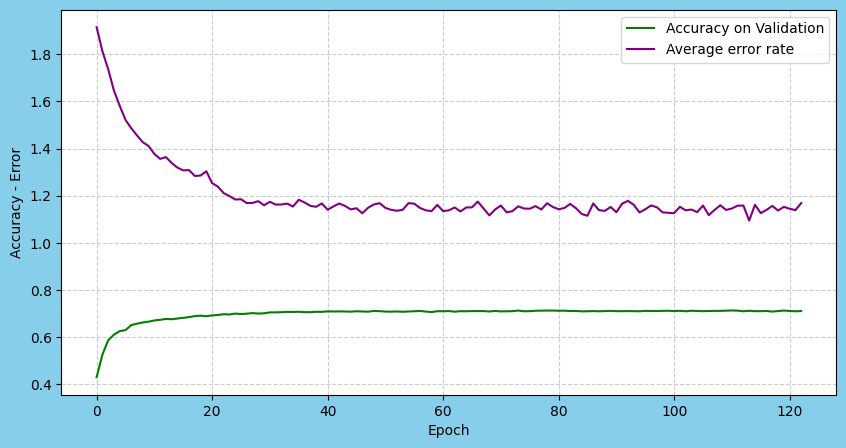

In [84]:
the_ax = print_loss_val(loss_values,val_values)
the_ax

In [14]:
#train cnn model with glove vectors on Train
glove_150_cnn_mod = EmbedCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=150,ker_sizes=[2,4,5])
glove_mod.load_state_dict(torch.load('/home/luchian/all_data/uni_data/glove_model_weights.pth',weights_only=True))
glove_150_cnn_mod.embed.weight = glove_mod.embed.weight
glove_150_cnn_mod.to(device = 'cuda')

EmbedCNNMod(
  (embed): Embedding(57568, 150, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 150), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(4, 150), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(5, 150), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=942, stride=942, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

In [103]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
main_loader = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=35)
epoch = 70
lr = 9*10**-6
optimizer_glove_cnn_main = torch.optim.Adam(lr = lr,params = glove_150_cnn_mod.parameters(),betas = (0.9,0.99))

In [104]:
#time
cnn_glove_res_main = train_classification_model(glove_150_cnn_mod,
                                           epoch,
                                           main_loader,
                                           optimizer_glove_cnn_main,
                                           loss_func,
                                           TestDataset,
                                           dev = 'cuda')

Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 1 | Loss: 1.9629125270300996 | Val acc: 0.32291 | Best acc on epoch #1



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.86it/s]


Epoch # 2 | Loss: 1.9061011134864327 | Val acc: 0.37692 | Best acc on epoch #2



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 3 | Loss: 1.885976202473669 | Val acc: 0.41785 | Best acc on epoch #3



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.83it/s]


Epoch # 4 | Loss: 1.8677164648107425 | Val acc: 0.4531 | Best acc on epoch #4



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.83it/s]


Epoch # 5 | Loss: 1.848646854033727 | Val acc: 0.47072 | Best acc on epoch #5



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 6 | Loss: 1.8345244905191982 | Val acc: 0.50028 | Best acc on epoch #6



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 7 | Loss: 1.8097859872672373 | Val acc: 0.53383 | Best acc on epoch #7



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.86it/s]


Epoch # 8 | Loss: 1.7887302317662153 | Val acc: 0.53667 | Best acc on epoch #8



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.89it/s]


Epoch # 9 | Loss: 1.7720297121716118 | Val acc: 0.54747 | Best acc on epoch #9



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.86it/s]


Epoch # 10 | Loss: 1.7630984003315429 | Val acc: 0.56964 | Best acc on epoch #10



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 11 | Loss: 1.7384424512971661 | Val acc: 0.57874 | Best acc on epoch #11



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.83it/s]


Epoch # 12 | Loss: 1.7251105474497743 | Val acc: 0.59125 | Best acc on epoch #12



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.86it/s]


Epoch # 13 | Loss: 1.7015206531850164 | Val acc: 0.59864 | Best acc on epoch #13



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.87it/s]


Epoch # 14 | Loss: 1.6903168772330541 | Val acc: 0.60489 | Best acc on epoch #14



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.89it/s]


Epoch # 15 | Loss: 1.6720179478208461 | Val acc: 0.60659 | Best acc on epoch #15



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.91it/s]


Epoch # 16 | Loss: 1.6529589886972291 | Val acc: 0.61626 | Best acc on epoch #16



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.91it/s]


Epoch # 17 | Loss: 1.635664129863956 | Val acc: 0.62138 | Best acc on epoch #17



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 18 | Loss: 1.6152353192160944 | Val acc: 0.62251 | Best acc on epoch #18



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.91it/s]


Epoch # 19 | Loss: 1.594463115234575 | Val acc: 0.62251 | Best acc on epoch #18



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 20 | Loss: 1.593178178914293 | Val acc: 0.63047 | Best acc on epoch #20



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 21 | Loss: 1.5728089928091644 | Val acc: 0.63388 | Best acc on epoch #21



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.85it/s]


Epoch # 22 | Loss: 1.5558053018625624 | Val acc: 0.63673 | Best acc on epoch #22



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.92it/s]


Epoch # 23 | Loss: 1.5445193716151986 | Val acc: 0.63957 | Best acc on epoch #23



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.90it/s]


Epoch # 24 | Loss: 1.5364286631881119 | Val acc: 0.63957 | Best acc on epoch #23



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 25 | Loss: 1.5159320063933641 | Val acc: 0.64412 | Best acc on epoch #25



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 26 | Loss: 1.500823245612447 | Val acc: 0.64696 | Best acc on epoch #26



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.90it/s]


Epoch # 27 | Loss: 1.4975297714243392 | Val acc: 0.64525 | Best acc on epoch #26



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 28 | Loss: 1.4865935360064764 | Val acc: 0.65037 | Best acc on epoch #28



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 29 | Loss: 1.4859688352503462 | Val acc: 0.65037 | Best acc on epoch #28



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 30 | Loss: 1.458439425883179 | Val acc: 0.65208 | Best acc on epoch #30



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.95it/s]


Epoch # 31 | Loss: 1.44565589618897 | Val acc: 0.65208 | Best acc on epoch #30



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 32 | Loss: 1.4308992899998934 | Val acc: 0.65719 | Best acc on epoch #32



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 33 | Loss: 1.4382908952807238 | Val acc: 0.65719 | Best acc on epoch #32



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 14.00it/s]


Epoch # 34 | Loss: 1.447386040123637 | Val acc: 0.66117 | Best acc on epoch #34



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 14.00it/s]


Epoch # 35 | Loss: 1.414953782351431 | Val acc: 0.66345 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.97it/s]


Epoch # 36 | Loss: 1.3892994523940685 | Val acc: 0.66117 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 37 | Loss: 1.4072783352015261 | Val acc: 0.66117 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.90it/s]


Epoch # 38 | Loss: 1.408107476587781 | Val acc: 0.66458 | Best acc on epoch #38



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 39 | Loss: 1.3759403304603999 | Val acc: 0.66401 | Best acc on epoch #38



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 40 | Loss: 1.3868371516823055 | Val acc: 0.66401 | Best acc on epoch #38



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 41 | Loss: 1.3760898272969766 | Val acc: 0.66515 | Best acc on epoch #41



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 42 | Loss: 1.3374016181437556 | Val acc: 0.66515 | Best acc on epoch #41



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.89it/s]


Epoch # 43 | Loss: 1.3550695305812859 | Val acc: 0.66742 | Best acc on epoch #43



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.99it/s]


Epoch # 44 | Loss: 1.3493410267694268 | Val acc: 0.66856 | Best acc on epoch #44



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.95it/s]


Epoch # 45 | Loss: 1.337897551006186 | Val acc: 0.67084 | Best acc on epoch #45



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 46 | Loss: 1.3554940841155139 | Val acc: 0.6714 | Best acc on epoch #46



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.97it/s]


Epoch # 47 | Loss: 1.3221228519778052 | Val acc: 0.66856 | Best acc on epoch #46



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 48 | Loss: 1.327524880806129 | Val acc: 0.67254 | Best acc on epoch #48



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 49 | Loss: 1.316478126375618 | Val acc: 0.67482 | Best acc on epoch #49



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.95it/s]


Epoch # 50 | Loss: 1.329017115121116 | Val acc: 0.67311 | Best acc on epoch #49



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.99it/s]


Epoch # 51 | Loss: 1.3268767770179017 | Val acc: 0.67311 | Best acc on epoch #49



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.95it/s]


Epoch # 52 | Loss: 1.2865940393088107 | Val acc: 0.67482 | Best acc on epoch #52



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 53 | Loss: 1.306372726525732 | Val acc: 0.67482 | Best acc on epoch #52



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 54 | Loss: 1.315537434361295 | Val acc: 0.67595 | Best acc on epoch #54



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 55 | Loss: 1.2947923900213785 | Val acc: 0.67709 | Best acc on epoch #55



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 56 | Loss: 1.3010512422658727 | Val acc: 0.67652 | Best acc on epoch #55



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 57 | Loss: 1.3044868713010571 | Val acc: 0.67823 | Best acc on epoch #57



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 58 | Loss: 1.3068976360791458 | Val acc: 0.67936 | Best acc on epoch #58



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 59 | Loss: 1.267942953787878 | Val acc: 0.67993 | Best acc on epoch #59



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 60 | Loss: 1.3066554095841454 | Val acc: 0.6805 | Best acc on epoch #60



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 14.00it/s]


Epoch # 61 | Loss: 1.2554983298578661 | Val acc: 0.67823 | Best acc on epoch #60



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 62 | Loss: 1.2543520628513691 | Val acc: 0.67936 | Best acc on epoch #62



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.95it/s]


Epoch # 63 | Loss: 1.2815329738541277 | Val acc: 0.68107 | Best acc on epoch #63



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 64 | Loss: 1.2613464199051172 | Val acc: 0.6805 | Best acc on epoch #63



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.92it/s]


Epoch # 65 | Loss: 1.2599532306194305 | Val acc: 0.68221 | Best acc on epoch #65



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 66 | Loss: 1.2534045613186802 | Val acc: 0.68107 | Best acc on epoch #65



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 67 | Loss: 1.27390185404502 | Val acc: 0.68562 | Best acc on epoch #67



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.97it/s]


Epoch # 68 | Loss: 1.2235013443285119 | Val acc: 0.68789 | Best acc on epoch #68



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 69 | Loss: 1.2561635850610848 | Val acc: 0.68675 | Best acc on epoch #68



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.99it/s]


Epoch # 70 | Loss: 1.25434267284449 | Val acc: 0.68732 | Best acc on epoch #70



In [105]:
#time
cnn_glove_res_main_2 = train_classification_model(glove_150_cnn_mod,
                                           50,
                                           main_loader,
                                           optimizer_glove_cnn_main,
                                           loss_func,
                                           TestDataset,
                                           dev = 'cuda')

Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 1 | Loss: 1.2588801578044178 | Val acc: 0.68391 | Best acc on epoch #1



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.79it/s]


Epoch # 2 | Loss: 1.249368454524857 | Val acc: 0.68789 | Best acc on epoch #2



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.85it/s]


Epoch # 3 | Loss: 1.2457135422322565 | Val acc: 0.68789 | Best acc on epoch #2



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.88it/s]


Epoch # 4 | Loss: 1.2347650381173203 | Val acc: 0.68619 | Best acc on epoch #2



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.91it/s]


Epoch # 5 | Loss: 1.2327142642911322 | Val acc: 0.68619 | Best acc on epoch #2



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 6 | Loss: 1.2380397944393273 | Val acc: 0.68619 | Best acc on epoch #2



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.82it/s]


Epoch # 7 | Loss: 1.2396470341764525 | Val acc: 0.68789 | Best acc on epoch #7



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.83it/s]


Epoch # 8 | Loss: 1.2254343475410325 | Val acc: 0.68619 | Best acc on epoch #7



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.87it/s]


Epoch # 9 | Loss: 1.2176632911948386 | Val acc: 0.68789 | Best acc on epoch #9



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.87it/s]


Epoch # 10 | Loss: 1.2326188756677205 | Val acc: 0.68675 | Best acc on epoch #9



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 11 | Loss: 1.2232389310876766 | Val acc: 0.68675 | Best acc on epoch #9



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.86it/s]


Epoch # 12 | Loss: 1.2132957929711856 | Val acc: 0.68732 | Best acc on epoch #12



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 13 | Loss: 1.2384744098265015 | Val acc: 0.69073 | Best acc on epoch #13



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.88it/s]


Epoch # 14 | Loss: 1.2098283983187048 | Val acc: 0.68789 | Best acc on epoch #13



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.83it/s]


Epoch # 15 | Loss: 1.216461805035611 | Val acc: 0.68675 | Best acc on epoch #13



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.90it/s]


Epoch # 16 | Loss: 1.2201939810535865 | Val acc: 0.68846 | Best acc on epoch #16



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.88it/s]


Epoch # 17 | Loss: 1.1845644274336136 | Val acc: 0.68789 | Best acc on epoch #16



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.87it/s]


Epoch # 18 | Loss: 1.2041085448539899 | Val acc: 0.68903 | Best acc on epoch #18



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.78it/s]


Epoch # 19 | Loss: 1.1943668784227914 | Val acc: 0.68903 | Best acc on epoch #18



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.85it/s]


Epoch # 20 | Loss: 1.2162562035871838 | Val acc: 0.69073 | Best acc on epoch #20



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.83it/s]


Epoch # 21 | Loss: 1.2121554952627884 | Val acc: 0.69358 | Best acc on epoch #21



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.85it/s]


Epoch # 22 | Loss: 1.2083985039038572 | Val acc: 0.69187 | Best acc on epoch #21



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.88it/s]


Epoch # 23 | Loss: 1.179767832159996 | Val acc: 0.69187 | Best acc on epoch #21



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.88it/s]


Epoch # 24 | Loss: 1.2231914524189726 | Val acc: 0.69016 | Best acc on epoch #21



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.85it/s]


Epoch # 25 | Loss: 1.203483405450504 | Val acc: 0.69187 | Best acc on epoch #25



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.92it/s]


Epoch # 26 | Loss: 1.1980343139367904 | Val acc: 0.69187 | Best acc on epoch #25



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.90it/s]


Epoch # 27 | Loss: 1.213014100349235 | Val acc: 0.69016 | Best acc on epoch #25



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.92it/s]


Epoch # 28 | Loss: 1.1905856024094685 | Val acc: 0.69471 | Best acc on epoch #28



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 29 | Loss: 1.204571437737542 | Val acc: 0.69016 | Best acc on epoch #28



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.90it/s]


Epoch # 30 | Loss: 1.1884337242491945 | Val acc: 0.69471 | Best acc on epoch #30



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 31 | Loss: 1.1829435331468097 | Val acc: 0.69073 | Best acc on epoch #30



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.92it/s]


Epoch # 32 | Loss: 1.2110230058966995 | Val acc: 0.69414 | Best acc on epoch #32



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 33 | Loss: 1.1833550715428627 | Val acc: 0.69471 | Best acc on epoch #33



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 34 | Loss: 1.195085971833703 | Val acc: 0.69358 | Best acc on epoch #33



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.89it/s]


Epoch # 35 | Loss: 1.206859963293561 | Val acc: 0.69358 | Best acc on epoch #33



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 36 | Loss: 1.1895230832749497 | Val acc: 0.69301 | Best acc on epoch #33



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 37 | Loss: 1.1682418160988186 | Val acc: 0.69358 | Best acc on epoch #37



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 38 | Loss: 1.1769295586440378 | Val acc: 0.69414 | Best acc on epoch #38



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 39 | Loss: 1.1744089541945628 | Val acc: 0.69528 | Best acc on epoch #39



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 40 | Loss: 1.1646809990623754 | Val acc: 0.69528 | Best acc on epoch #39



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 41 | Loss: 1.1814461788329893 | Val acc: 0.69983 | Best acc on epoch #41



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 42 | Loss: 1.1913505461133882 | Val acc: 0.69869 | Best acc on epoch #41



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.99it/s]


Epoch # 43 | Loss: 1.1853996457721658 | Val acc: 0.69585 | Best acc on epoch #41



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 44 | Loss: 1.160688601121931 | Val acc: 0.69812 | Best acc on epoch #44



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 45 | Loss: 1.192573127186227 | Val acc: 0.70097 | Best acc on epoch #45



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 46 | Loss: 1.176568318983752 | Val acc: 0.69756 | Best acc on epoch #45



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 47 | Loss: 1.1563469937550808 | Val acc: 0.69869 | Best acc on epoch #47



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 48 | Loss: 1.172053291813699 | Val acc: 0.69812 | Best acc on epoch #47



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 49 | Loss: 1.1572342969164877 | Val acc: 0.69699 | Best acc on epoch #47



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 50 | Loss: 1.1677473699618242 | Val acc: 0.69642 | Best acc on epoch #47



In [106]:
#time
cnn_glove_res_main_3 = train_classification_model(glove_150_cnn_mod,
                                           50,
                                           main_loader,
                                           optimizer_glove_cnn_main,
                                           loss_func,
                                           TestDataset,
                                           dev = 'cuda')

Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.87it/s]


Epoch # 1 | Loss: 1.166490462413448 | Val acc: 0.69983 | Best acc on epoch #1



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 2 | Loss: 1.1573472253665953 | Val acc: 0.69869 | Best acc on epoch #1



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.87it/s]


Epoch # 3 | Loss: 1.1606074536587307 | Val acc: 0.69926 | Best acc on epoch #3



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.88it/s]


Epoch # 4 | Loss: 1.1881685810620912 | Val acc: 0.69983 | Best acc on epoch #4



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.89it/s]


Epoch # 5 | Loss: 1.1327829982438486 | Val acc: 0.69983 | Best acc on epoch #4



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.84it/s]


Epoch # 6 | Loss: 1.1654452680203016 | Val acc: 0.69983 | Best acc on epoch #4



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.83it/s]


Epoch # 7 | Loss: 1.1476502269952598 | Val acc: 0.7004 | Best acc on epoch #7



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.89it/s]


Epoch # 8 | Loss: 1.1732341215728286 | Val acc: 0.70097 | Best acc on epoch #8



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.92it/s]


Epoch # 9 | Loss: 1.1766986891538083 | Val acc: 0.70097 | Best acc on epoch #8



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.86it/s]


Epoch # 10 | Loss: 1.1607672138485365 | Val acc: 0.7004 | Best acc on epoch #8



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.87it/s]


Epoch # 11 | Loss: 1.1693954997790788 | Val acc: 0.70097 | Best acc on epoch #11



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.91it/s]


Epoch # 12 | Loss: 1.173831311840854 | Val acc: 0.70153 | Best acc on epoch #12



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.86it/s]


Epoch # 13 | Loss: 1.165417379917142 | Val acc: 0.70153 | Best acc on epoch #12



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.89it/s]


Epoch # 14 | Loss: 1.1657740413071866 | Val acc: 0.70267 | Best acc on epoch #14



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.90it/s]


Epoch # 15 | Loss: 1.1570613143775992 | Val acc: 0.70097 | Best acc on epoch #14



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 16 | Loss: 1.148186636408289 | Val acc: 0.70153 | Best acc on epoch #16



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.90it/s]


Epoch # 17 | Loss: 1.1518951371133686 | Val acc: 0.70153 | Best acc on epoch #16



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 18 | Loss: 1.136475727943603 | Val acc: 0.70153 | Best acc on epoch #16



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 19 | Loss: 1.1600191145689187 | Val acc: 0.70153 | Best acc on epoch #16



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.91it/s]


Epoch # 20 | Loss: 1.1396285618493658 | Val acc: 0.7021 | Best acc on epoch #20



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 21 | Loss: 1.1555687230147287 | Val acc: 0.70381 | Best acc on epoch #21



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 22 | Loss: 1.1570059848492018 | Val acc: 0.70324 | Best acc on epoch #21



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.92it/s]


Epoch # 23 | Loss: 1.1995171007817378 | Val acc: 0.70153 | Best acc on epoch #21



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.92it/s]


Epoch # 24 | Loss: 1.128475986376494 | Val acc: 0.7021 | Best acc on epoch #24



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 25 | Loss: 1.1624158943841558 | Val acc: 0.70438 | Best acc on epoch #25



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 26 | Loss: 1.15991472359189 | Val acc: 0.70438 | Best acc on epoch #25



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.91it/s]


Epoch # 27 | Loss: 1.171804122225253 | Val acc: 0.70381 | Best acc on epoch #25



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 28 | Loss: 1.156338286123233 | Val acc: 0.70267 | Best acc on epoch #25



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 29 | Loss: 1.1612544274794128 | Val acc: 0.70495 | Best acc on epoch #29



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 30 | Loss: 1.152840083676898 | Val acc: 0.70324 | Best acc on epoch #29



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.92it/s]


Epoch # 31 | Loss: 1.172852591661636 | Val acc: 0.7021 | Best acc on epoch #29



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.92it/s]


Epoch # 32 | Loss: 1.1550320161138465 | Val acc: 0.70267 | Best acc on epoch #32



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.90it/s]


Epoch # 33 | Loss: 1.1554996732644691 | Val acc: 0.70381 | Best acc on epoch #33



Going through the loader: 100%|██████████| 668/668 [00:48<00:00, 13.90it/s]


Epoch # 34 | Loss: 1.1494225910056137 | Val acc: 0.70153 | Best acc on epoch #33



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 35 | Loss: 1.1377094430837802 | Val acc: 0.70324 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.92it/s]


Epoch # 36 | Loss: 1.1502978802173438 | Val acc: 0.70267 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.95it/s]


Epoch # 37 | Loss: 1.1490517613327431 | Val acc: 0.70267 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 38 | Loss: 1.1711481176985952 | Val acc: 0.70267 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.95it/s]


Epoch # 39 | Loss: 1.1681925080671995 | Val acc: 0.70267 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.93it/s]


Epoch # 40 | Loss: 1.1644140954859956 | Val acc: 0.7021 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 41 | Loss: 1.1284233788976412 | Val acc: 0.7021 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 42 | Loss: 1.1460771522300686 | Val acc: 0.7021 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.99it/s]


Epoch # 43 | Loss: 1.160070232779323 | Val acc: 0.7021 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 14.00it/s]


Epoch # 44 | Loss: 1.158350227567964 | Val acc: 0.7021 | Best acc on epoch #35



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.96it/s]


Epoch # 45 | Loss: 1.157921298847584 | Val acc: 0.70267 | Best acc on epoch #45



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.97it/s]


Epoch # 46 | Loss: 1.1654831641270016 | Val acc: 0.70324 | Best acc on epoch #46



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.94it/s]


Epoch # 47 | Loss: 1.1648750769164034 | Val acc: 0.70267 | Best acc on epoch #46



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.97it/s]


Epoch # 48 | Loss: 1.15379521342184 | Val acc: 0.70381 | Best acc on epoch #48



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 13.98it/s]


Epoch # 49 | Loss: 1.1267136877436124 | Val acc: 0.70438 | Best acc on epoch #49



Going through the loader: 100%|██████████| 668/668 [00:47<00:00, 14.00it/s]


Epoch # 50 | Loss: 1.1322895876260217 | Val acc: 0.70495 | Best acc on epoch #50



In [ ]:
# torch.save(glove_150_cnn_mod.state_dict(),'/home/luchian/prog/self_prog/Projects/TextClassification/glove_150_cnn_mod.pth')

In [ ]:
# an_mode.load_state_dict(torch.load('/home/luchian/prog/self_prog/Projects/TextClassification/glove_150_cnn_mod.pth',weights_only=True))

<All keys matched successfully>

результат похож на остальные но заметим что тут размерность 150

In [111]:
get_accuracy(an_mode,TestDataset)

0.70495

тестируем некоторые архитектуры рекуррентных нейронных сетей    
последняя из них была выбрана

In [15]:
class ResBlock(nn.Module):
    def __init__(self,in_size = 150,hid_size = 150,drop_rate = 0.5):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=in_size,hidden_size=hid_size,batch_first = True)
        self.drop = nn.Dropout1d(p = drop_rate)
    def forward(self,x):
        #res 1
        y = x.transpose(0,1)
        _,(y,_) = self.lstm1(y)
        y += x
        y = self.drop(y)
        return y

In [17]:
#Train RNN's
class RNNMod(nn.Module):
    def __init__(self,vocab_size,embed_dim,hid_size = 350):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim)
        self.lstm1 = nn.LSTM(input_size = embed_dim,hidden_size = hid_size,batch_first = True)
        self.block1 = ResBlock(in_size = hid_size,hid_size=hid_size,drop_rate=0.35)
        self.block2 = ResBlock(in_size = hid_size,hid_size=hid_size,drop_rate = 0.15)
        self.lin = nn.Linear(hid_size,7)

    def forward(self,inds_list):
        y = self.embed(inds_list)
        _,(y,_) = self.lstm1(y)
        y = self.block1(y)
        y = self.block2(y)

        y = y.squeeze(dim = 0)
        y = self.lin(y)
        return y

тут используем двунаправленную архитеткуры рекуррентных нейронных сетей LSTM (подробнее смотреть в аналитической записке)

In [83]:
#Train RNN's
class RNNMod(nn.Module):
    def __init__(self,vocab_size,embed_dim,hid_size = 150,bi = False):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim)
        self.lstm1 = nn.LSTM(input_size = embed_dim,hidden_size = hid_size,batch_first = True,bidirectional = bi)
        self.lin = nn.Linear(2*hid_size if bi else hid_size,7)

    def forward(self,inds_list):
        y = self.embed(inds_list)
        _,(y,_) = self.lstm1(y)
        y = y.transpose(0,1)
        y = y.reshape(y.shape[0],-1)
        y = self.lin(y)
        return y

In [68]:
one_value = next(iter(train_loader_val_glove_rnn))
one_value[0].shape

torch.Size([10, 945])

In [69]:
one_value[0].shape

torch.Size([10, 945])

In [70]:
the_mod = RNNMod(Train_tokenizer.get_vocab_size(),embed_dim=300,bi = True)
the_mod(one_value[0]).shape

torch.Size([10, 7])

In [71]:
Train_val_np, Val_val_np = train_test_split(Train_news,stratify=Train_news['topic'],train_size = 0.9)
print(len(Train_val_np))
print(len(Val_val_np))

21027
2337


In [72]:
Train_val_tensor = NewsDataset(Train_val_np,le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))
Val_val_tensor = NewsDataset(Val_val_np,le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))
print(len(Train_val_tensor))
print(len(Val_val_tensor))

21027
2337


In [82]:
ngram_300_rnn_mod = RNNMod(Train_tokenizer.get_vocab_size(),embed_dim=300,hid_size = 150,bi = True)
ngram_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/ngram_300_embeddings_epoch#9.pth',weights_only=True))
ngram_300_rnn_mod.embed.weight = ngram_model.embed.weight
ngram_300_rnn_mod.to(device = 'cuda')

RNNMod(
  (embed): Embedding(57568, 300)
  (lstm1): LSTM(300, 150, batch_first=True, bidirectional=True)
  (lin): Linear(in_features=300, out_features=7, bias=True)
)

In [83]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_loader_val_ngram_rnn = DataLoader(dataset = Train_val_tensor,shuffle=True,batch_size=10)
epoch = 50
lr = 5*10**-5
optimizer_val_ngram_rnn = torch.optim.Adam(params = ngram_300_rnn_mod.parameters(),
                                           lr = lr,
                                           betas = (0.9,0.999))


как обычно проводим обучения для каждого типа векторных представлений

In [127]:
def train_classification_model(the_model,epoch,loader,optimizer,loss_func,val_dataset,dev = 'cuda'):
    average_ep_losses = []
    best_epoch = None
    val_accs = []
    try:
        for one_ep in range(epoch):
            the_model.train()
            the_losses = []
            for X,y in tqdm(loader,desc = 'Going through the loader'):
                X,y = X.to(device = dev),y.to(device = dev)
                optimizer.zero_grad()
                y_pred = the_model(X)
                the_loss = loss_func(y_pred,y)
                the_loss.backward()
                the_losses.append(the_loss.item())
                optimizer.step()
            if one_ep%1== 0:
                avg_loss = np.array(the_losses).mean()
                average_ep_losses.append(avg_loss)
                val_score = get_accuracy(the_model,val_dataset,dev =dev)
                val_accs.append(val_score)

                if best_epoch == None:
                    best_epoch = one_ep + 1
                else:
                    best_epoch = one_ep + 1 if val_accs[-1] > val_accs[-2] else best_epoch

                print(f'Epoch # {one_ep+1} | Loss: {avg_loss} | Val acc: {val_score} | Best acc on epoch #{best_epoch}',end = '\n\n')
        return best_epoch,average_ep_losses,val_accs
    except KeyboardInterrupt:
        return best_epoch,average_ep_losses,val_accs

In [84]:
rnn_val_res = train_classification_model(ngram_300_rnn_mod,
                                        30,
                                        train_loader_val_ngram_rnn,
                                        optimizer_val_ngram_rnn,
                                        loss_func,
                                        Val_val_tensor,
                                        dev = 'cuda')

Going through the loader: 100%|██████████| 2103/2103 [02:25<00:00, 14.49it/s]


Epoch # 1 | Loss: 1.767588238006425 | Val acc: 0.46341 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2103/2103 [02:26<00:00, 14.39it/s]


Epoch # 2 | Loss: 1.3902384818195446 | Val acc: 0.69833 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2103/2103 [03:20<00:00, 10.51it/s]


Epoch # 3 | Loss: 0.9297968710582709 | Val acc: 0.77493 | Best acc on epoch #3



In [85]:
rnn_val_res_2 = train_classification_model(ngram_300_rnn_mod,
                                        15,
                                        train_loader_val_ngram_rnn,
                                        optimizer_val_ngram_rnn,
                                        loss_func,
                                        Val_val_tensor,
                                        dev = 'cuda')

Going through the loader: 100%|██████████| 2103/2103 [03:23<00:00, 10.33it/s]


Epoch # 1 | Loss: 0.6842917821844362 | Val acc: 0.81686 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2103/2103 [35:52<00:00,  1.02s/it]  


Epoch # 2 | Loss: 0.5552977318129282 | Val acc: 0.84938 | Best acc on epoch #2



Going through the loader:  62%|██████▏   | 1308/2103 [16:17<09:54,  1.34it/s]  


In [86]:
rnn_val_res_3 = train_classification_model(ngram_300_rnn_mod,
                                        15,
                                        train_loader_val_ngram_rnn,
                                        optimizer_val_ngram_rnn,
                                        loss_func,
                                        Val_val_tensor,
                                        dev = 'cuda')

Going through the loader: 100%|██████████| 2103/2103 [02:27<00:00, 14.21it/s]


Epoch # 1 | Loss: 0.43275927229466904 | Val acc: 0.86521 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2103/2103 [10:54<00:00,  3.22it/s]


Epoch # 2 | Loss: 0.36861497011740707 | Val acc: 0.87634 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2103/2103 [19:46<00:00,  1.77it/s]


Epoch # 3 | Loss: 0.32034512737759707 | Val acc: 0.87035 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2103/2103 [20:33<00:00,  1.70it/s]


Epoch # 4 | Loss: 0.26698040067941425 | Val acc: 0.89217 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2103/2103 [19:36<00:00,  1.79it/s]


Epoch # 5 | Loss: 0.22376537658670528 | Val acc: 0.88019 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2103/2103 [19:46<00:00,  1.77it/s]


Epoch # 6 | Loss: 0.1950612410259067 | Val acc: 0.89944 | Best acc on epoch #6



Going through the loader:  49%|████▊     | 1021/2103 [09:03<09:36,  1.88it/s]


In [87]:
rnn_val_res_4 = train_classification_model(ngram_300_rnn_mod,
                                        15,
                                        train_loader_val_ngram_rnn,
                                        optimizer_val_ngram_rnn,
                                        loss_func,
                                        Val_val_tensor,
                                        dev = 'cuda')

Going through the loader: 100%|██████████| 2103/2103 [02:33<00:00, 13.68it/s]


Epoch # 1 | Loss: 0.14369287143107787 | Val acc: 0.88789 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2103/2103 [17:36<00:00,  1.99it/s]


Epoch # 2 | Loss: 0.12128129310872054 | Val acc: 0.89388 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2103/2103 [18:28<00:00,  1.90it/s]


Epoch # 3 | Loss: 0.09492635262070097 | Val acc: 0.88318 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2103/2103 [18:21<00:00,  1.91it/s]


Epoch # 4 | Loss: 0.0748735611351128 | Val acc: 0.89388 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2103/2103 [17:46<00:00,  1.97it/s]


Epoch # 5 | Loss: 0.06860120689864631 | Val acc: 0.90201 | Best acc on epoch #5



Going through the loader: 100%|██████████| 2103/2103 [17:44<00:00,  1.97it/s]


Epoch # 6 | Loss: 0.048861171441382203 | Val acc: 0.90244 | Best acc on epoch #6



Going through the loader: 100%|██████████| 2103/2103 [16:56<00:00,  2.07it/s]


Epoch # 7 | Loss: 0.04173304410891575 | Val acc: 0.90757 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2103/2103 [17:16<00:00,  2.03it/s]


Epoch # 8 | Loss: 0.034620223434407134 | Val acc: 0.90586 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2103/2103 [17:29<00:00,  2.00it/s]


Epoch # 9 | Loss: 0.032671835582754945 | Val acc: 0.90929 | Best acc on epoch #9



Going through the loader: 100%|██████████| 2103/2103 [17:44<00:00,  1.98it/s]


Epoch # 10 | Loss: 0.028977935428780577 | Val acc: 0.90843 | Best acc on epoch #9



Going through the loader: 100%|██████████| 2103/2103 [17:14<00:00,  2.03it/s]


Epoch # 11 | Loss: 0.019116370863038672 | Val acc: 0.908 | Best acc on epoch #9



Going through the loader: 100%|██████████| 2103/2103 [24:33<00:00,  1.43it/s]  


Epoch # 12 | Loss: 0.01736699607822731 | Val acc: 0.91228 | Best acc on epoch #12



Going through the loader: 100%|██████████| 2103/2103 [27:14<00:00,  1.29it/s] 


Epoch # 13 | Loss: 0.01606704661814676 | Val acc: 0.91185 | Best acc on epoch #12



Going through the loader: 100%|██████████| 2103/2103 [32:02<00:00,  1.09it/s]  


Epoch # 14 | Loss: 0.012826096089435583 | Val acc: 0.91356 | Best acc on epoch #14



Going through the loader: 100%|██████████| 2103/2103 [32:11<00:00,  1.09it/s]  


Epoch # 15 | Loss: 0.010948793096748512 | Val acc: 0.91271 | Best acc on epoch #14



In [90]:
the_rnn_losses = rnn_val_res[1] + rnn_val_res_2[1] + rnn_val_res_3[1] + rnn_val_res_4[1]
the_rnn_scores = rnn_val_res[2] + rnn_val_res_2[2] + rnn_val_res_3[2] + rnn_val_res_4[2]

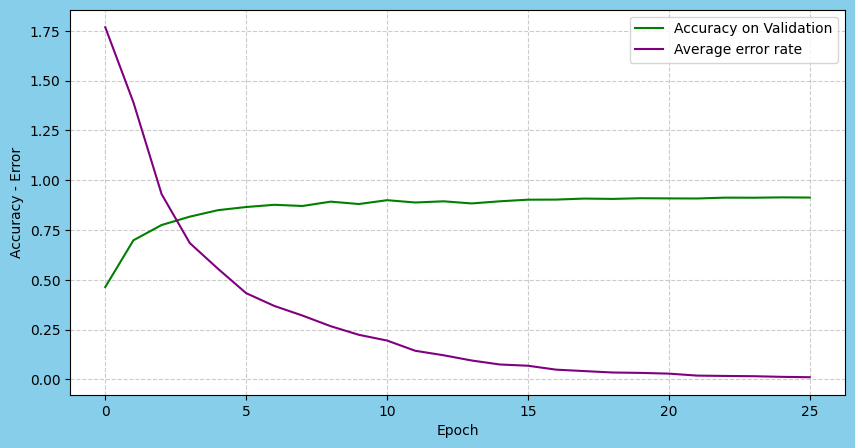

In [105]:
the_ax = print_loss_val(the_rnn_losses,the_rnn_scores,val_name = 'Validation')

In [106]:
the_ax.savefig('lstm.png')

In [107]:
!pwd

/home/luchian/prog/self_prog/Projects/TextClassification


In [108]:
#train lstm on training set with ngram_300 embeddings
ngram_300_rnn_mod = RNNMod(Train_tokenizer.get_vocab_size(),embed_dim=300,hid_size = 150,bi = True)
ngram_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/ngram_300_embeddings_epoch#9.pth',weights_only=True))
ngram_300_rnn_mod.embed.weight = ngram_model.embed.weight
ngram_300_rnn_mod.to(device = 'cuda')

RNNMod(
  (embed): Embedding(57568, 300)
  (lstm1): LSTM(300, 150, batch_first=True, bidirectional=True)
  (lin): Linear(in_features=300, out_features=7, bias=True)
)

In [111]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_loader_ngram_rnn = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 50
lr = 5*10**-5
optimizer_loader_ngram_rnn = torch.optim.Adam(params = ngram_300_rnn_mod.parameters(),
                                           lr = lr,
                                           betas = (0.9,0.999))


In [115]:
rnn_main_res1 = train_classification_model(ngram_300_rnn_mod,
                                        15,
                                        train_loader_ngram_rnn,
                                        optimizer_loader_ngram_rnn,
                                        loss_func,
                                        TestDataset,
                                        dev = 'cuda')

Going through the loader: 100%|██████████| 2337/2337 [02:58<00:00, 13.07it/s]


Epoch # 1 | Loss: 1.7515779513296634 | Val acc: 0.47641 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [03:14<00:00, 12.03it/s]


Epoch # 2 | Loss: 1.3017746847207392 | Val acc: 0.76066 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2337/2337 [13:40<00:00,  2.85it/s]


Epoch # 3 | Loss: 0.8958805681715983 | Val acc: 0.81069 | Best acc on epoch #3



Going through the loader: 100%|██████████| 2337/2337 [20:26<00:00,  1.91it/s]


Epoch # 4 | Loss: 0.7070336320003512 | Val acc: 0.83002 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2337/2337 [15:52<00:00,  2.45it/s]


Epoch # 5 | Loss: 0.5707917145947947 | Val acc: 0.85219 | Best acc on epoch #5



Going through the loader:   6%|▌         | 133/2337 [00:11<03:04, 11.92it/s]


In [121]:
rnn_main_res2 = train_classification_model(ngram_300_rnn_mod,
                                        25,
                                        train_loader_ngram_rnn,
                                        optimizer_loader_ngram_rnn,
                                        loss_func,
                                        TestDataset,
                                        dev = 'cuda')

Going through the loader: 100%|██████████| 2337/2337 [03:08<00:00, 12.42it/s]


Epoch # 1 | Loss: 0.48088390606498943 | Val acc: 0.87152 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [12:14<00:00,  3.18it/s]


Epoch # 2 | Loss: 0.41658262180496813 | Val acc: 0.86981 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [14:43<00:00,  2.65it/s]


Epoch # 3 | Loss: 0.3451706784875776 | Val acc: 0.88346 | Best acc on epoch #3



Going through the loader: 100%|██████████| 2337/2337 [15:27<00:00,  2.52it/s]


Epoch # 4 | Loss: 0.29855263344827954 | Val acc: 0.89937 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2337/2337 [16:00<00:00,  2.43it/s]


Epoch # 5 | Loss: 0.25581648396599077 | Val acc: 0.8772 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2337/2337 [16:36<00:00,  2.35it/s]


Epoch # 6 | Loss: 0.21011633216712272 | Val acc: 0.90165 | Best acc on epoch #6



Going through the loader: 100%|██████████| 2337/2337 [17:16<00:00,  2.26it/s]


Epoch # 7 | Loss: 0.17293005166228606 | Val acc: 0.89255 | Best acc on epoch #6



Going through the loader: 100%|██████████| 2337/2337 [17:19<00:00,  2.25it/s]


Epoch # 8 | Loss: 0.13741625835758403 | Val acc: 0.90279 | Best acc on epoch #8



Going through the loader: 100%|██████████| 2337/2337 [17:24<00:00,  2.24it/s]


Epoch # 9 | Loss: 0.11124065246823163 | Val acc: 0.90733 | Best acc on epoch #9



Going through the loader: 100%|██████████| 2337/2337 [18:18<00:00,  2.13it/s]


Epoch # 10 | Loss: 0.08602573863156124 | Val acc: 0.91245 | Best acc on epoch #10



In [ ]:
# torch.save(ngram_300_rnn_mod.state_dict(),'/home/luchian/prog/self_prog/Projects/TextClassification/ngram_300_rnn_mod.pth')

In [ ]:
# lo_gram = RNNMod(Train_tokenizer.get_vocab_size(),embed_dim=300,hid_size = 150,bi = True)
# lo_gram.load_state_dict(torch.load('/home/luchian/prog/self_prog/Projects/TextClassification/ngram_300_rnn_mod.pth',weights_only=True))

полученный результат для ngram

In [ ]:
# get_accuracy(lo_gram,TestDataset)

0.91245

In [8]:
#model for glove emebeddings
glove_150_rnn_mod = RNNMod(Train_tokenizer.get_vocab_size(),embed_dim=150,bi = True)
glove_mod.load_state_dict(torch.load('/home/luchian/all_data/uni_data/glove_model_weights.pth',weights_only = True))
glove_150_rnn_mod.embed.weight = glove_mod.embed.weight
glove_150_rnn_mod.to(device = 'cuda')

RNNMod(
  (embed): Embedding(57568, 150)
  (lstm1): LSTM(150, 150, batch_first=True, bidirectional=True)
  (lin): Linear(in_features=300, out_features=7, bias=True)
)

In [14]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_main_glove_rnn = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 16
lr = 5*10**-5
optimizer_main_glove_rnn = torch.optim.Adam(lr = lr,params = glove_150_rnn_mod.parameters(),betas = (0.9,0.99))

In [ ]:
#the model was trained in google colab (see google_train.ipynb)
glove_rnn_res = train_classification_model(glove_150_rnn_mod,
                           epoch,
                           train_main_glove_rnn,
                           optimizer_main_glove_rnn,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'glove_150_RNN')

теперь аналогично обучаем ту же рекуррентную нейронку на cbow and glove 

In [10]:
class CBOWModel(nn.Module):
    def __init__(self,vocab_size,dim_embed,window_size = 2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed)
        self.linear1 = nn.Linear(dim_embed,128)
        self.linear2 = nn.Linear(128,vocab_size)
        self.rel = nn.ReLU()

    def forward(self,ind_list):
        y = self.embed(ind_list).sum(dim = 1)
        y = self.rel(self.linear1(y))
        y = self.rel(self.linear2(y))
        return y

In [11]:
cbow_model = CBOWModel(Train_tokenizer.get_vocab_size(),dim_embed = 300,window_size = 2)

In [12]:
#model for cbow embeddings 
cbow_300_rnn_mod = RNNMod(Train_tokenizer.get_vocab_size(),embed_dim=300,bi = True)
cbow_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/1_epoch#15.pth',weights_only=True))
cbow_300_rnn_mod.embed.weight = cbow_model.embed.weight
cbow_300_rnn_mod.to(device = 'cuda')

RNNMod(
  (embed): Embedding(57568, 300)
  (lstm1): LSTM(300, 150, batch_first=True, bidirectional=True)
  (lin): Linear(in_features=300, out_features=7, bias=True)
)

In [46]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_main_cbow_rnn = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 16
lr = 5*10**-5
optimizer_main_cbow_rnn = torch.optim.Adam(lr = lr,params = cbow_300_rnn_mod.parameters(),betas = (0.9,0.99))

In [ ]:
#the model was trained in google colab (see google_train.ipynb)
cbow_rnn_res = train_classification_model(cbow_300_rnn_mod,
                           epoch,
                           train_main_cbow_rnn,
                           optimizer_main_cbow_rnn,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'cbow_300_RNN')

модели были обучены в google colab

In [13]:
glove_150_rnn_mod.load_state_dict(torch.load('/home/luchian/prog/self_prog/Projects/TextClassification/glove_150_RNN_weights.pth',weights_only = True))

<All keys matched successfully>

In [14]:
cbow_300_rnn_mod.load_state_dict(torch.load('/home/luchian/prog/self_prog/Projects/TextClassification/cbow_300_RNN_weights.pth',weights_only=True))

<All keys matched successfully>

получены следующие результаты

In [16]:
get_accuracy(glove_150_rnn_mod,TestDataset)

0.89937

In [17]:
get_accuracy(cbow_300_rnn_mod,TestDataset)

0.91074

In [ ]:
#trainsformer model with positional encoding

функция реализующая позициональное кодирование, котороне требуется для моделей transformers

In [8]:
class PositionalEncoding():
    @torch.no_grad()
    def __init__(self,vocab_size,embed_dim,calc = True,dev = 'cuda'):
        '''Calculates the positional ecnodings'''
        self.d_model = embed_dim
        self.pos_embed = nn.Embedding(vocab_size,embed_dim).to(device = dev)
        if calc == True:
            for ind in range(vocab_size):
                pos_tensor = torch.tensor([
                    math.sin((ind+1)/10_000**(2*i/self.d_model)) 
                    if i%2 == 0 
                    else 
                    math.cos((ind+1)/10_000**(2*i/self.d_model)) 
                    for i in range(self.d_model)
                ])
                self.pos_embed.weight[ind] = pos_tensor
        else:
            pass

    def __call__(self,the_inds):
        return self.pos_embed(the_inds)

моель Transformer Encoder (подробнее смотреть в аналитической записке)

In [13]:
class TransformerModel(nn.Module):
    def __init__(self,d_mod = 300,nhead = 6,encoder_layers = 6,batch_first = True,dev = 'cuda',vocab_size = Train_tokenizer.get_vocab_size()):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,d_mod)
        self.single_encoder = nn.TransformerEncoderLayer(d_model = d_mod,nhead=nhead,batch_first = batch_first)
        self.full_encoder = nn.TransformerEncoder(encoder_layer = self.single_encoder,num_layers = encoder_layers)
        self.pos_encoder = PositionalEncoding(vocab_size = vocab_size,embed_dim = d_mod,calc = True,dev = dev)
        self.rnn = nn.RNN(input_size=d_mod,hidden_size=100,batch_first=batch_first)
        self.linear = nn.Linear(100,7)
    def forward(self,the_inds):
        embeds = self.embed(the_inds)
        pos_encodings = self.pos_encoder(the_inds)
        final_embed = embeds + pos_encodings
        y = self.full_encoder(final_embed)
        _,y = self.rnn(y)
        y = y.squeeze(dim = 0)
        y = self.linear(y)
        return y


далее для всех векторных представлений модели были обычным образом обучены (некоторые из них в google colab) смотреть аналитичсекую записку и google_train.ipynb

In [124]:
#Train Transformer model with skip_gram embeddings
ngram_300_transformer_mod = TransformerModel(d_mod = 300,
                               nhead = 6,
                               encoder_layers = 3,
                               batch_first = True,
                               dev = 'cuda',
                               vocab_size = Train_tokenizer.get_vocab_size()).to(device = 'cuda')
ngram_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/ngram_300_embeddings_epoch#9.pth',weights_only=True))
ngram_300_transformer_mod.embed.weight = ngram_model.embed.weight
ngram_300_transformer_mod.to(device = 'cuda')

TransformerModel(
  (embed): Embedding(57568, 300)
  (single_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
    )
    (linear1): Linear(in_features=300, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=300, bias=True)
    (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (full_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_features=300, out_features=2048, bias=True)
        (dropout): Dro

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_main_ngram_transformers = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 10
lr = 5*10**-5
optimizer_main_ngram_transformers = torch.optim.Adam(lr = lr,params = ngram_300_transformer_mod.parameters(),betas = (0.9,0.99))

In [ ]:
#the moel was trained in google.colab
ngram_transformer_res = train_classification_model(ngram_300_transformer_mod,
                           epoch,
                           train_main_ngram_transformers,
                           optimizer_main_ngram_transformers,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'ngram_300_Transformer')

In [125]:
ngram_300_transformer_mod.load_state_dict(torch.load(f = '/home/luchian/prog/self_prog/Projects/TextClassification/ngram_300_Transformer_weights.pth',weights_only = True))

<All keys matched successfully>

получен хороший результат для векторных представлений ngram

In [18]:
get_accuracy(ngram_300_transformer_mod,TestDataset)

0.91188

In [ ]:
#Train Transformer model with cbow embeddings
cbow_300_transformer_mod = TransformerModel(d_mod = 300,
                               nhead = 6,
                               encoder_layers = 3,
                               batch_first = True,
                               dev = 'cuda',
                               vocab_size = Train_tokenizer.get_vocab_size()).to(device = 'cuda')
cbow_model.load_state_dict(torch.load('1_epoch#15.pth',weights_only=True))
cbow_300_transformer_mod.embed.weight = cbow_model.embed.weight
cbow_300_transformer_mod.to(device = 'cuda')

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_main_cbow_transformers = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 10
lr = 5*10**-5
optimizer_main_cbow_transformers = torch.optim.Adam(lr = lr,params = cbow_300_transformer_mod.parameters(),betas = (0.9,0.99))

далее представлены процессы для cbow и glove

In [ ]:
cbow_300_transformer_mod.load_state_dict(torch.load(f = '/home/luchian/prog/self_prog/Projects/TextClassification/cbow_300_Transformer_weights.pth',weights_only = True))

<All keys matched successfully>

In [20]:
get_accuracy(cbow_300_transformer_mod,TestDataset)

0.9187

In [ ]:
#the model was trained in google colab
cbow_transformer_res = train_classification_model(cbow_300_transformer_mod,
                           epoch,
                           train_main_cbow_transformers,
                           optimizer_main_cbow_transformers,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'cbow_300_Transformer')

In [23]:
#Train Transformer model with glove embeddings
glove_150_transformer_mod = TransformerModel(d_mod = 150,
                               nhead = 6,
                               encoder_layers = 3,
                               batch_first = True,
                               dev = 'cuda',
                               vocab_size = Train_tokenizer.get_vocab_size()).to(device = 'cuda')
glove_mod.load_state_dict(torch.load('/home/luchian/all_data/uni_data/glove_model_weights.pth',weights_only = True))
glove_150_transformer_mod.embed.weight = glove_mod.embed.weight
glove_150_transformer_mod.to(device = 'cuda')

TransformerModel(
  (embed): Embedding(57568, 150)
  (single_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=150, out_features=150, bias=True)
    )
    (linear1): Linear(in_features=150, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=150, bias=True)
    (norm1): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (full_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=150, out_features=150, bias=True)
        )
        (linear1): Linear(in_features=150, out_features=2048, bias=True)
        (dropout): Dro

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_main_glove_transformers = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 10
lr = 5*10**-5
optimizer_main_glove_transformers = torch.optim.Adam(lr = lr,params = glove_150_transformer_mod.parameters(),betas = (0.9,0.99))

In [ ]:
glove_transformer_res = train_classification_model(glove_150_transformer_mod,
                           epoch,
                           train_main_glove_transformers,
                           optimizer_main_glove_transformers,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'glove_150_Transformer')

In [25]:
glove_150_transformer_mod.load_state_dict(torch.load(f = '/home/luchian/prog/self_prog/Projects/TextClassification/glove_150_Transformer_weights.pth',weights_only = True))

<All keys matched successfully>

In [26]:
get_accuracy(glove_150_transformer_mod,TestDataset)

0.91529

тут происходит процесс создания таблицы для всех моделей содержащая в секбе все метрики 

также реализована функция инференса для наилучшей модели

In [54]:
def get_predictions(model,dataset,dev = 'cuda'):
    """returns all preditions of the model"""
    model.eval()
    y_values = []
    y_pred_values = []
    the_loader = DataLoader(dataset = dataset,shuffle=False,batch_size=1)
    for X,y in the_loader:
        X,y = X.to(device = dev),y.to(device = dev)
        y_pred = model(X).softmax(dim = 1).argmax(dim = 1).detach().item()
        y = y.item()
        y_values.append(y)
        y_pred_values.append(y_pred)
    return y_values,y_pred_values

In [68]:
def get_my_metris(model,dataset,dev = 'cuda'):
    """returns accuracy, precision, and recall"""
    y_true,y_pred = get_predictions(model,dataset,dev)
    the_dict = {
        'accuracy': accuracy_score(y_true = y_true,y_pred = y_pred),
        'precision': precision_score(y_true = y_true,y_pred = y_pred,average='macro'),
        'recall': recall_score(y_true = y_true,y_pred = y_pred,average = 'macro')  
    }
    return the_dict

In [79]:
some_dict = get_my_metris(model=glove_150_transformer_mod,dataset=TestDataset,dev = 'cuda')

In [73]:
cbow_mod_weights = [
    '/home/luchian/prog/self_prog/Projects/TextClassification/cbow_300_cnn_mod_epoch#13.pth', #cnn
    '/home/luchian/prog/self_prog/Projects/TextClassification/cbow_300_RNN_weights.pth', #rnn
    '/home/luchian/prog/self_prog/Projects/TextClassification/cbow_300_Transformer_weights.pth' # transformer
]

In [74]:
ngram_mod_weights = [
    '/home/luchian/prog/self_prog/Projects/TextClassification/ngram_300_cnn_mod_epoch#20.pth', #cnn
    '/home/luchian/prog/self_prog/Projects/TextClassification/ngram_300_rnn_mod.pth', #rnn
    '/home/luchian/prog/self_prog/Projects/TextClassification/ngram_300_Transformer_weights.pth' # transformer
]

In [76]:
glove_mod_weights = [
    '/home/luchian/prog/self_prog/Projects/TextClassification/glove_150_cnn_mod.pth', #cnn
    '/home/luchian/prog/self_prog/Projects/TextClassification/glove_150_RNN_weights.pth', #rnn
    '/home/luchian/prog/self_prog/Projects/TextClassification/glove_150_Transformer_weights.pth' #transformer
]

In [89]:
all_weights = [
    ngram_mod_weights,
    cbow_mod_weights,
    glove_mod_weights
]

In [97]:
models = [
    EmbedCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=300,ker_sizes=[2,4,5]).to(device='cuda'), #cnn 300
    RNNMod(Train_tokenizer.get_vocab_size(),embed_dim=300,bi = True).to(device='cuda'), #rnn 300
    TransformerModel(d_mod = 300,nhead = 6,encoder_layers = 3,batch_first = True,dev = 'cuda',vocab_size = Train_tokenizer.get_vocab_size()).to(device = 'cuda'), #transformer 300
    EmbedCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=150,ker_sizes=[2,4,5]).to(device='cuda'), #cnn 150
    RNNMod(Train_tokenizer.get_vocab_size(),embed_dim=150,bi = True).to(device='cuda'), #rnn 150
    TransformerModel(d_mod = 150,nhead = 6,encoder_layers = 3,batch_first = True,dev = 'cuda',vocab_size = Train_tokenizer.get_vocab_size()).to(device = 'cuda'), #transformer 150
]

создаем нужную таблицу

In [78]:
res_table = pd.DataFrame(columns=['CNN/ngram','RNN/ngram','Transformer/ngram','CNN/cbow','RNN/cbow','Transformer/cbow','CNN/glove','RNN/glove','Transformer/glove'],index = ['accuracy','precision','recall'])
res_table

,CNN/ngram,RNN/ngram,Transformer/ngram,CNN/cbow,RNN/cbow,Transformer/cbow,CNN/glove,RNN/glove,Transformer/glove
accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


создаем функцию заполняющуя данную талицу

In [103]:
for embed_ind in range(3):
    weights = all_weights[embed_ind]
    for mod_ind in range(3):
        if embed_ind != 2:
            models[mod_ind].load_state_dict(torch.load(f = weights[mod_ind],weights_only = True))
        else:
            models[mod_ind + 3].load_state_dict(torch.load(f = weights[mod_ind],weights_only = True))
    ###
    if embed_ind != 2:
        for mod_ind in range(3):
            the_mod = models[mod_ind]
            results = get_my_metris(the_mod,TestDataset)
            for k in range(3):
                res_table.iloc[k,mod_ind + 3*embed_ind] = results[list(results.keys())[k]]
    else:
        for mod_ind in range(3):
            the_mod = models[mod_ind + 3]
            results = get_my_metris(the_mod,TestDataset)
            for k in range(3):
                res_table.iloc[k,mod_ind + 3*embed_ind] = results[list(results.keys())[k]]


/home/luchian/prog/venv-MyPython/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luchian/prog/venv-MyPython/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luchian/prog/venv-MyPython/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [104]:
res_table

,CNN/ngram,RNN/ngram,Transformer/ngram,CNN/cbow,RNN/cbow,Transformer/cbow,CNN/glove,RNN/glove,Transformer/glove
accuracy,0.712905,0.91245,0.911882,0.702103,0.910745,0.918704,0.704946,0.899375,0.915293
precision,0.399556,0.725892,0.762562,0.395023,0.697529,0.729894,0.451661,0.700634,0.736322
recall,0.558678,0.794635,0.759552,0.543359,0.731711,0.744777,0.616459,0.752406,0.744632


тут мы создаем функцию, которая будем по введенному тексту выдавать названия темы новости

In [144]:
def model_inference(the_text,dev = 'cuda'):
    """returns a label using the text as an input"""
    tokens = normalize_text(the_text)
    inds = [Train_tokenizer.token_to_id(token) if Train_tokenizer.token_to_id(token) != None else Train_tokenizer.token_to_id('[UNK]') for token in tokens]
    inds = torch.tensor(inds,dtype = torch.long)
    inds = Padding()(inds)
    inds = inds.reshape(1,-1)
    y_pred = ngram_300_transformer_mod(inds.to(device = 'cuda')).softmax(dim = 1).argmax(dim = 1).detach().item()
    the_clses = le.classes_.tolist()
    return the_clses[y_pred]

выбираем некоторые реальные новости 

In [164]:
some_texts = [
    ('Российский прыгун с шестом Александр Соловьев выиграл чемпионат американской Национальной ассоциации студенческого спорта (NCAA) в Юджине (штат Орегон).Соловьев победил с результатом 5,78 метра — он был единственным из участников, кто взял эту высоту.В прошлом году стало известно, что Соловьев, победитель Кубка России, поступил в Университет Техаса (Texas A&M University) и уехал учиться в США.','Спорт'),
    ('Президент США Дональд Трамп назвал «очень милыми» извинения предпринимателя Илона Маска, с которым у него ранее произошла ссора. Такое мнение глава государства высказал в беседе с изданием The New York Post. «Я считаю, что это очень мило с его стороны», — заявил Трамп.При этом президент США не ответил, готов ли он оставить в прошлом произошедшее между ним и предпринимателем, отмечает газета.Маск и Трамп публично поссорились после того, как бизнесмен раскритиковал «большой прекрасный законопроект» республиканцев о налоговых льготах, который увеличивает дефицит бюджета США. Маск, до начала июня руководивший сокращением госрасходов в администрации Трампа, назвал законопроект «отвратительной мерзостью». Президент заявил, что разочарован в Маске.','Политика'),
    ('Банк России анонсировал выпуск памятных серебряных монет номиналом 3 рубля — они войдут в обращение и будут приурочены к «100-летнему юбилею научно-технической разведки». Об этом пишет Центральный банк (ЦБ).Тираж монеты — 3 тыс. штук. На оборотной стороне серебряной монеты изобразят модель атома и надпись по окружности «научно-техническая разведка СВР России», двухголового орла — на лицевой. Все художественные элементы выполнят в рельефе, а центральную часть — эмблему Службы внешней разведки — сделают в цвете.','Финансы'),
    ('В 2027 году на территории России может не появиться ни одного нового дома либо объемы ввода жилья могут сократиться до 30%. Такой прогноз сделал вице-премьер Марат Хуснуллин в эфире телеканала «Россия 24».Хуснуллин подчеркнул, что сохраняется «серьезная нехорошая тенденция», которая связана с остановкой новых проектов в строительной сфере. «Это означает, что в 2027 году не будет ввода жилья или будет значительно меньше. Это первый тревожный фактор», — сказал он.Второй, заявил вице-премьер, касается ситуации, когда застройщики из-за нехватки средств на эскроу-счетах начинают замедлять темпы строительства уже начатых объектов. В результате запланированные сроки сдачи домов могут быть перенесены. «Если тенденция будет сохраняться, до 30% может быть падение», — заявил Хуснуллин.','экономика')
]

Для этих новостей попробуем провести инференс модели

представлены некоторые результаты инференса 

In [166]:
for one_text in some_texts:
    print(f'Some of the text: {one_text[0][:80]}')
    print(f'Model prediction: {model_inference(one_text[0])}')
    print(f'True label: {one_text[1]}')
    print(''.join(['-' for _ in range(100)]))
    print('\n\n')

Some of the text: Российский прыгун с шестом Александр Соловьев выиграл чемпионат американской Нац
Model prediction: Спорт
True label: Спорт
----------------------------------------------------------------------------------------------------



Some of the text: Президент США Дональд Трамп назвал «очень милыми» извинения предпринимателя Илон
Model prediction: Экономика
True label: Политика
----------------------------------------------------------------------------------------------------



Some of the text: Банк России анонсировал выпуск памятных серебряных монет номиналом 3 рубля — они
Model prediction: Финансы
True label: Финансы
----------------------------------------------------------------------------------------------------



Some of the text: В 2027 году на территории России может не появиться ни одного нового дома либо о
Model prediction: Экономика
True label: экономика
----------------------------------------------------------------------------------------------------



